In [1]:
!pip install prophet pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from prophet.plot import plot_yearly,plot_weekly,plot_components
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import ccf
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.graph_objects as go

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
daily = pd.read_csv('daily_final(probably).csv')

In [5]:
hourly = pd.read_csv('hourly.csv')
hourly.drop(columns='Unnamed: 0', inplace=True)

<ipython-input-5-50e3116916a0>:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly = pd.read_csv('hourly.csv')


In [6]:
monthly = pd.read_csv('monthly_data.csv')

In [7]:
monthly.iloc[:, 2:8] = monthly.iloc[:, 2:8]/(10**7)

<ipython-input-7-2aa5ebda7ae9>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     2.000000e-07
1     6.000000e-07
2     0.000000e+00
3     3.000000e-07
4     8.000000e-07
5     7.000000e-07
6     5.000000e-07
7     2.100000e-06
8     3.000000e-07
9     0.000000e+00
10    3.000000e-07
11    0.000000e+00
Name: sale, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly.iloc[:, 2:8] = monthly.iloc[:, 2:8]/(10**7)


# GENERAL INFO ABOUT DATASET

In [8]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745178 entries, 0 to 745177
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   fsn_id                         745178 non-null  object 
 1   order_date                     745178 non-null  object 
 2   order_id                       745178 non-null  float64
 3   order_item_id                  745178 non-null  float64
 4   gmv                            745178 non-null  float64
 5   units                          745178 non-null  int64  
 6   deliverybdays                  745178 non-null  int64  
 7   deliverycdays                  745178 non-null  int64  
 8   order_payment_type             745178 non-null  object 
 9   sla                            745178 non-null  int64  
 10  cust_id                        745178 non-null  object 
 11  pincode                        745178 non-null  object 
 12  product_mrp                   

In [9]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         375 non-null    object 
 1   deliverybdays                375 non-null    float64
 2   deliverycdays                375 non-null    float64
 3   sla                          375 non-null    float64
 4   product_procurement_sla      375 non-null    float64
 5   sale                         375 non-null    int64  
 6   NPS                          375 non-null    float64
 7   Stock Index                  375 non-null    float64
 8   holidays                     375 non-null    int64  
 9   Total Investment             375 non-null    float64
 10  TV                           375 non-null    float64
 11  Digital                      375 non-null    float64
 12  Sponsorship                  375 non-null    float64
 13  Content Marketing   

In [10]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   month                        12 non-null     object 
 1   deliverybdays                12 non-null     float64
 2   deliverycdays                12 non-null     float64
 3   sla                          12 non-null     float64
 4   product_mrp                  12 non-null     float64
 5   product_procurement_sla      12 non-null     float64
 6   sale                         12 non-null     float64
 7   NPS                          12 non-null     float64
 8   Stock Index                  12 non-null     float64
 9   holidays                     12 non-null     int64  
 10  Total Investment             12 non-null     float64
 11  TV                           12 non-null     float64
 12  Digital                      12 non-null     float64
 13  Sponsorship           

# GENERAL ANALYSIS

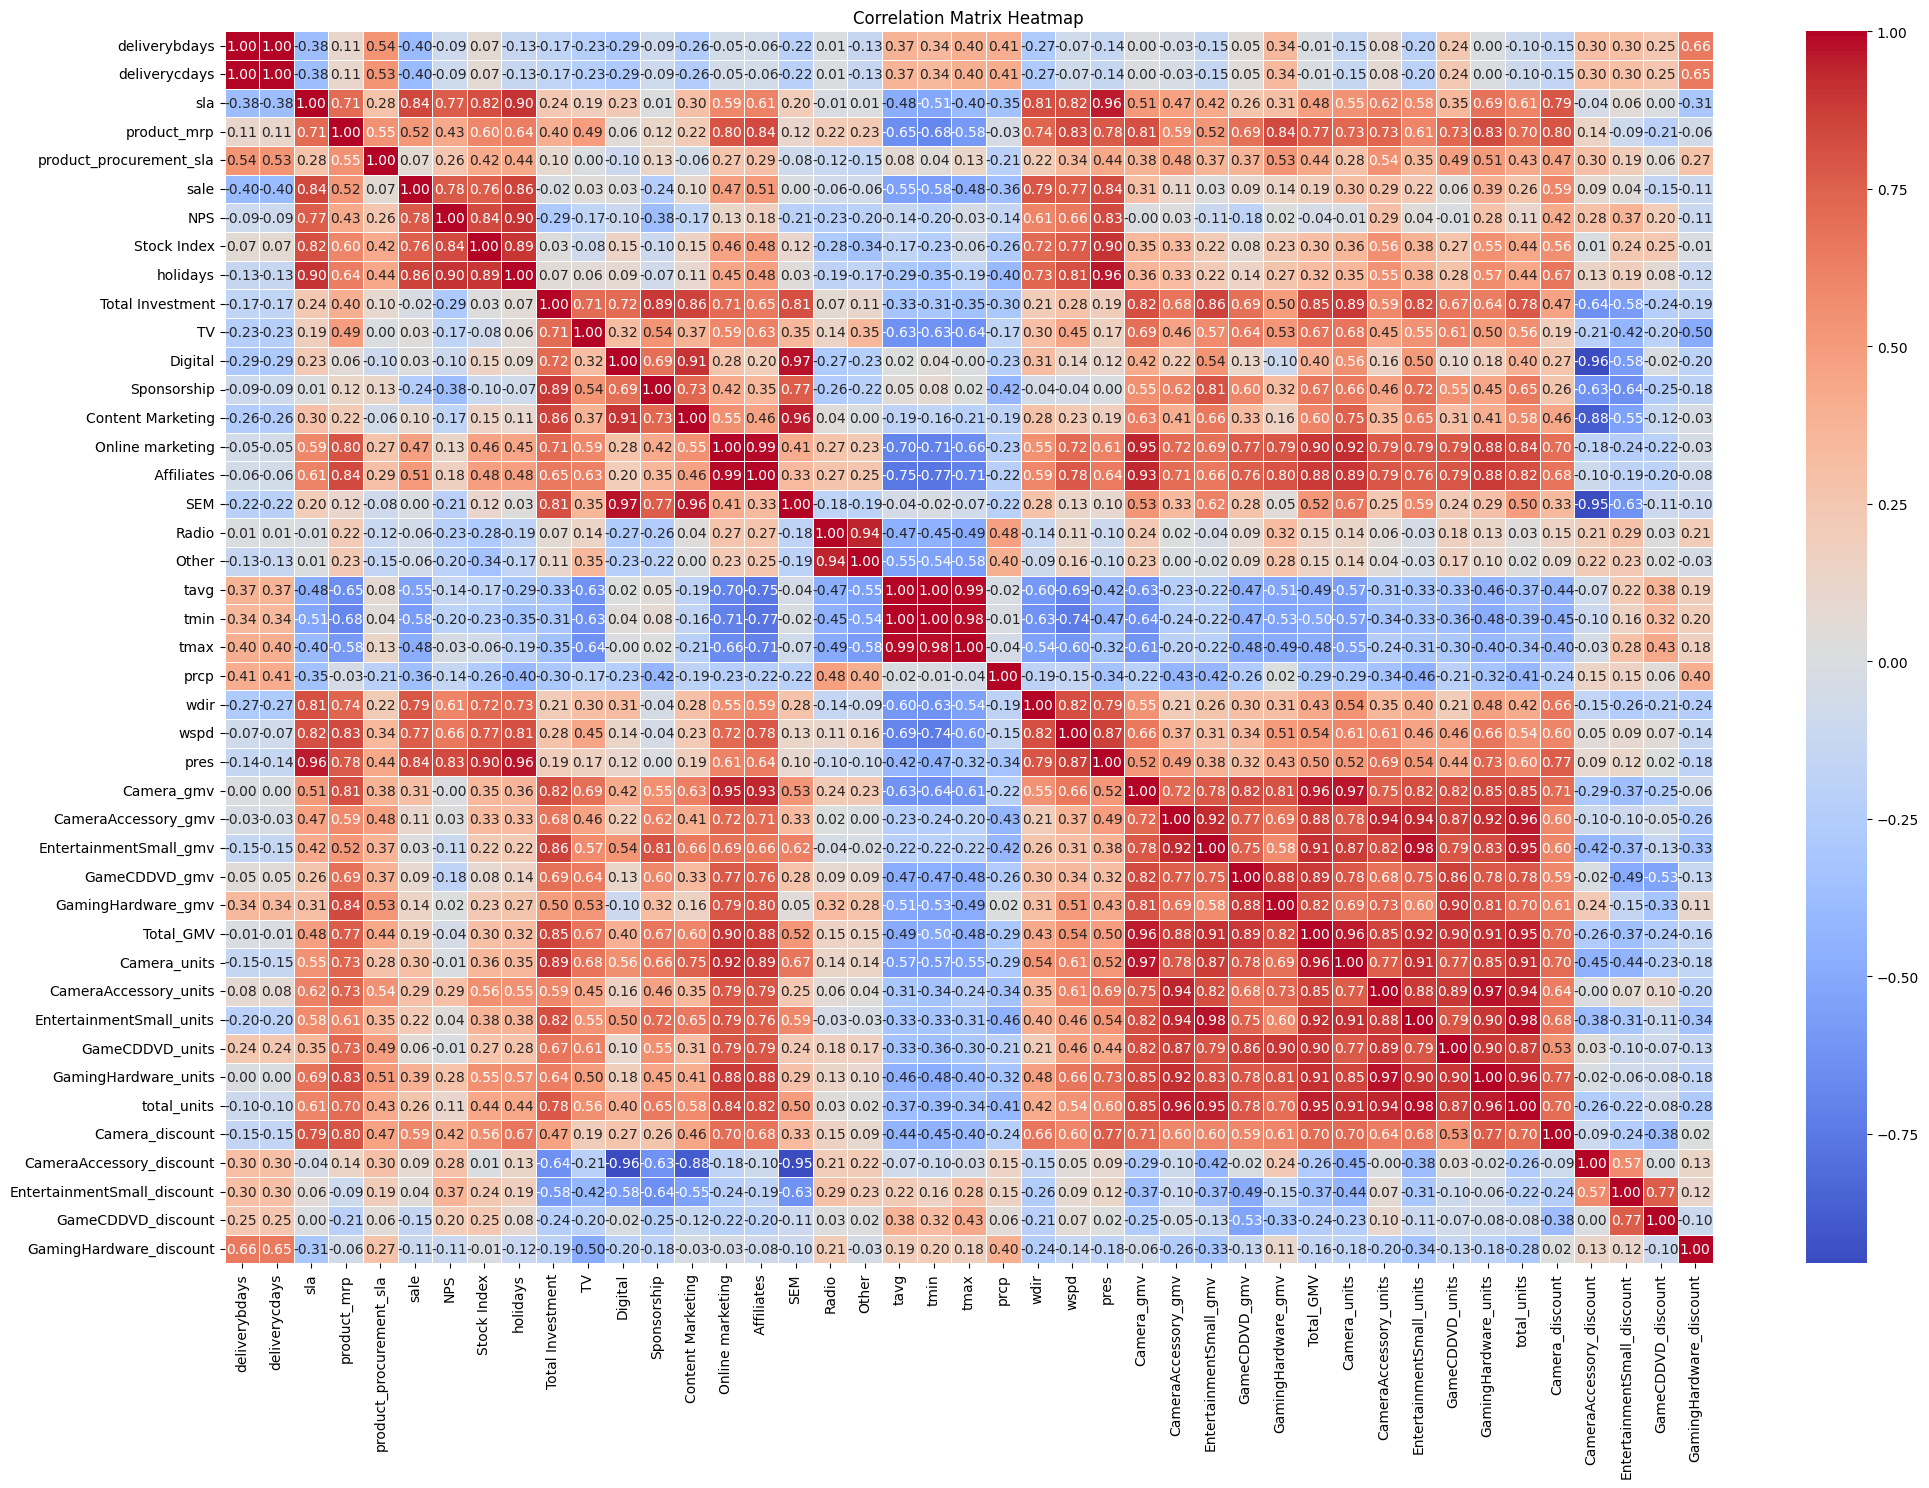

In [11]:
# Selecting only numeric columns
numeric_datax = monthly.select_dtypes(include=['number'])

# Computing the correlation matrix
correlation_matrix = numeric_datax.corr()

# Plotting the heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Plot
plt.title("Correlation Matrix Heatmap")
plt.show()

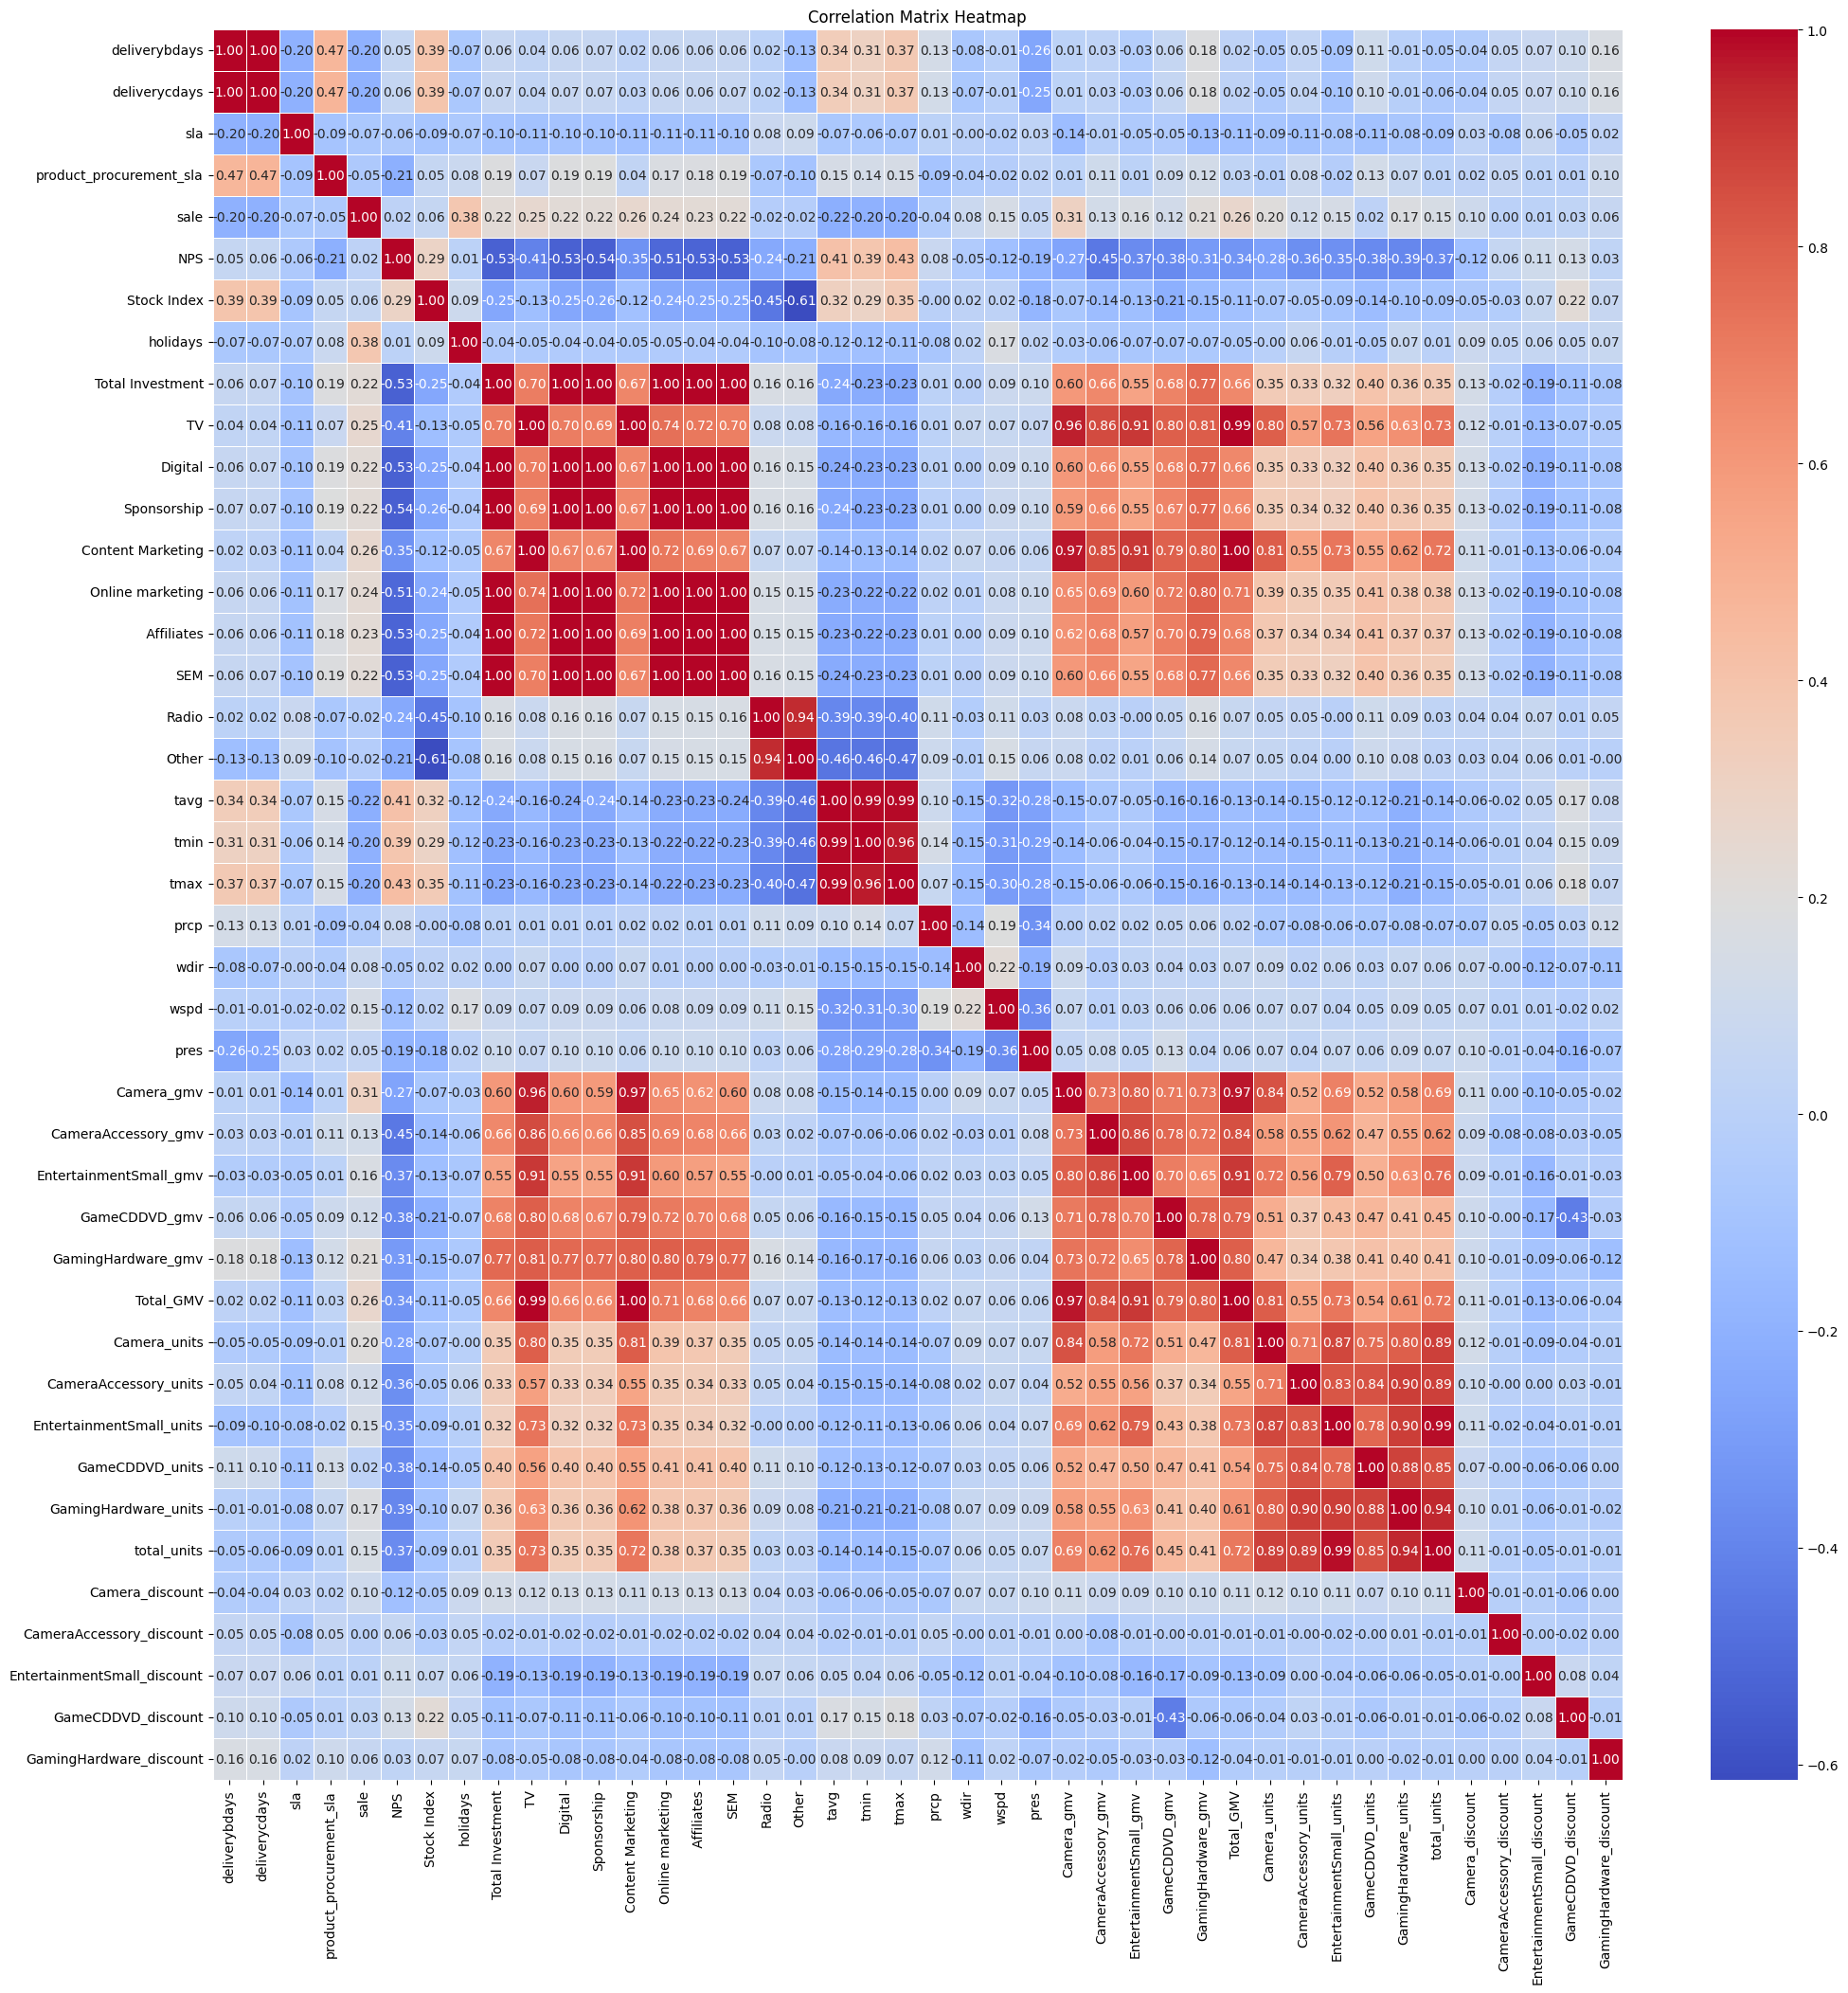

In [12]:
numeric_datax = daily.select_dtypes(include=['number'])

# Computing the correlation matrix
correlation_matrix = numeric_datax.corr()

# Plotting the heatmap
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Plot
plt.title("Correlation Matrix Heatmap")
plt.show()

In [13]:
hourly['discount'] = hourly['discount'].apply(lambda x : 0 if x <0 else x) # If discount is (negative) we made it zero.

# STATISTICAL


In [14]:
scipy.stats.kstest(hourly['gmv'], 'norm') # KS test results of "GMV" feature in hourly dataset

KstestResult(statistic=np.float64(0.9991169894978112), pvalue=np.float64(0.0), statistic_location=np.float64(10.0), statistic_sign=np.int8(-1))

In [15]:
scipy.stats.kstest(hourly['List_price'], 'norm') # KS test results of "List Price" feature in hourly dataset

KstestResult(statistic=np.float64(0.9991169894978112), pvalue=np.float64(0.0), statistic_location=np.float64(10.0), statistic_sign=np.int8(-1))

In [16]:
from scipy.stats import skew, kurtosis # Skewness and kurtosis values for hourly data
print("Skewness:", skew(hourly['gmv']))
print("Kurtosis:", kurtosis(hourly['gmv']))

Skewness: 77.64069660861121
Kurtosis: 20168.627333645887


In [17]:
data_log = np.log1p(hourly['gmv'])  # log(1 + x) to handle zeros
scipy.stats.kstest(data_log, 'norm')

KstestResult(statistic=np.float64(0.9990217037718001), pvalue=np.float64(0.0), statistic_location=np.float64(3.7612001156935624), statistic_sign=np.int8(-1))

In [18]:
#Doing independent T test of payment channels
group1 = hourly[hourly['order_payment_type']=='COD']['gmv']
group2 = hourly[hourly['order_payment_type']=='Prepaid']['gmv']
print(scipy.stats.ttest_ind(group1, group2))
print(scipy.stats.mannwhitneyu(group1, group2))

'''
Very strong difference between the groups hence highly likely different distribution
'''

TtestResult(statistic=np.float64(-96.66344019810117), pvalue=np.float64(0.0), df=np.float64(745176.0))
MannwhitneyuResult(statistic=np.float64(38195568036.5), pvalue=np.float64(0.0))


'\nVery strong difference between the groups hence highly likely different distribution\n'

In [19]:
#ANOVA ON PRODUCT CATEGORIES with reference to customer id (repeated measure anova)
import pingouin
'''
The effect of product category on revenue is significant (p-GG-corr < 0.05).
Sphericity is violated, so use the Greenhouse-Geisser corrected p-value (p-GG-corr).
The effect size (ng2 = 0.55) is very strong.
'''
print(pingouin.rm_anova(data=hourly, dv='gmv', within='product_analytic_category', subject='cust_id'))

                      Source  ddof1  ddof2         F     p-unc  p-GG-corr  \
0  product_analytic_category      4     12  3.065308  0.059042   0.156767   

        ng2       eps  sphericity       W-spher   p-spher  
0  0.382597  0.331473       False  8.982130e-12  0.000552  


# TIME SERIES

In [20]:
daily_sales = daily[['date','Total_GMV']]
daily_sales.columns = ['ds', 'y']  # Prophet requires these specific column names
# Fitting the model
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_country_holidays(country_name='CA')
m.fit(daily_sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdc21o085/vx656jcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdc21o085/ec2rtrvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38889', 'data', 'file=/tmp/tmpdc21o085/vx656jcm.json', 'init=/tmp/tmpdc21o085/ec2rtrvp.json', 'output', 'file=/tmp/tmpdc21o085/prophet_modelsrb66re5/prophet_model-20250321225959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


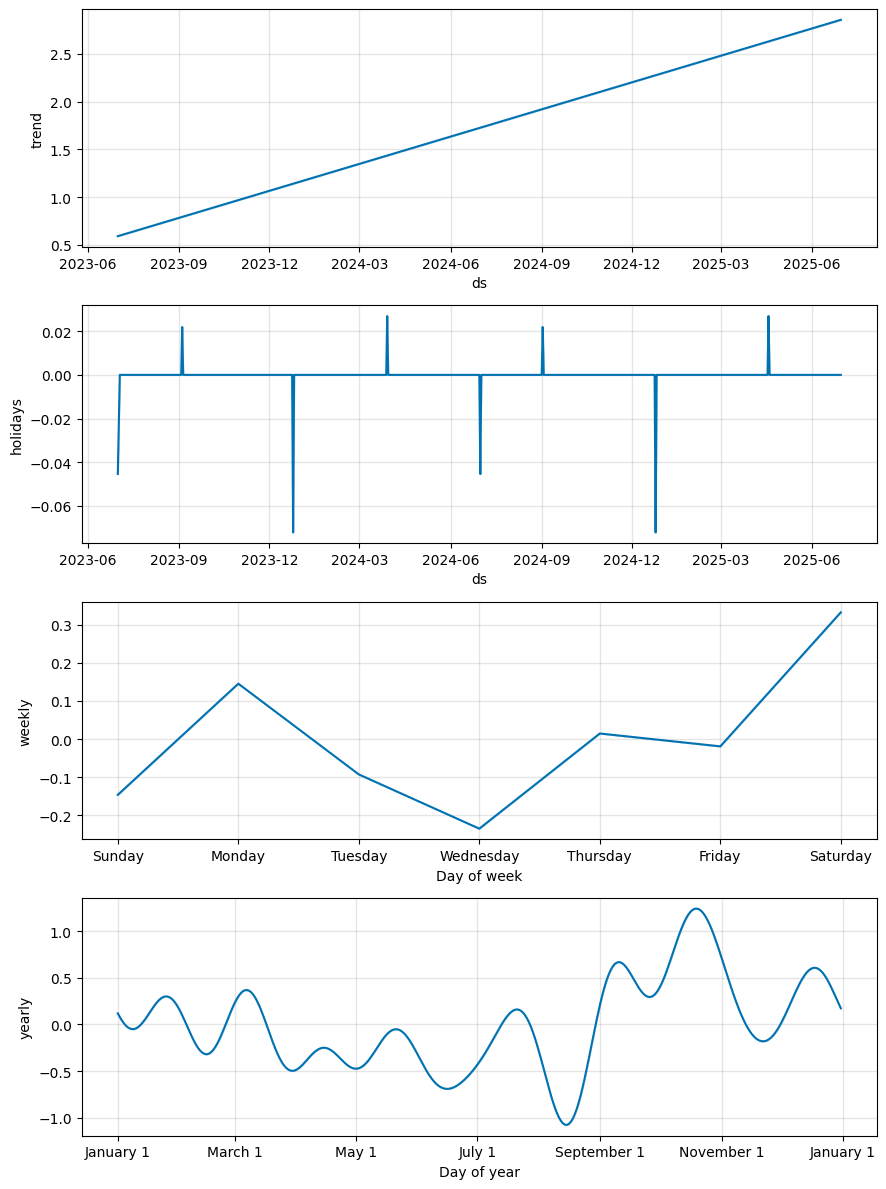

In [21]:
# Trend, effect of holidays , Seasonality(weekly), Seasonality (Yearly)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [22]:
daily

date  deliverybdays  deliverycdays       sla  \
0    2023-07-01       0.107143       0.107143  3.964286   
1    2023-07-03       0.788136       0.800847  2.313559   
2    2023-07-04       0.057143       0.085714  4.400000   
3    2023-07-05       0.000000       0.000000  8.000000   
4    2023-07-06       0.000000       0.000000  5.909091   
..          ...            ...            ...       ...   
370  2024-06-26       3.535771       3.698345  5.678324   
371  2024-06-27       3.474777       3.498813  4.627003   
372  2024-06-28       3.328229       3.583068  4.592892   
373  2024-06-29       3.155966       3.686966  4.511436   
374  2024-06-30       3.045538       3.710880  5.301650   

     product_procurement_sla  sale   NPS  Stock Index  holidays  \
0                   3.214286     0  54.6       1177.0         1   
1                   2.775424     0  54.6       1177.0         0   
2                   2.971429     0  54.6       1177.0         0   
3                   1.000000     0  54.6       1177.0         0   
4                   3.181818     0  54.6       1177.0         0   
..                       ...   ...   ...          ...       ...   
370                10.459690     0  50.5       1194.0         0   
371                10.827300     0  50.5       1194.0         0   
372                14.068766     0  50.5       1194.0         0   
373                 9.607605     0  50.5       1194.0         0   
374                14.699572     0  50.5       1194.0         0   

     Total Investment        TV    Digital  Sponsorship  Content Marketing  \
0            0.020588  0.000333   0.005118     0.004259       3.271611e-07   
1           12.040132  0.006900   3.040767     2.529412       8.364814e-06   
2            0.262768  0.001232   0.066086     0.054988       1.211623e-06   
3            0.000150  0.000024   0.000032     0.000026       2.360531e-08   
4            0.139804  0.000889   0.035102     0.029207       8.739995e-07   
..                ...       ...        ...          ...                ...   
370        175.406694  0.018863  44.357797    36.701174       6.142253e-05   
371        157.655875  0.017427  39.864539    33.005581       5.505012e-05   
372        164.149592  0.017948  41.508163    34.358098       5.736065e-05   
373        220.816666  0.022737  55.857756    46.131181       7.860635e-05   
374        151.250506  0.016918  38.243417    31.670836       5.279363e-05   

     Online marketing   Affiliates         SEM  Radio  Other  tavg  tmin  \
0            0.000517     0.000295    0.010066    0.0    0.0  24.3  20.9   
1            0.307672     0.175345    5.980027    0.0    0.0  23.2  19.7   
2            0.006681     0.003810    0.129970    0.0    0.0  23.6  19.5   
3            0.000003     0.000002    0.000062    0.0    0.0  25.5  20.8   
4            0.003549     0.002023    0.069034    0.0    0.0  24.6  21.9   
..                ...          ...         ...    ...    ...   ...   ...   
370          4.566863     2.574879   87.187056    0.0    0.0  24.0  22.0   
371          4.095387     2.312134   78.360753    0.0    0.0  19.5  15.4   
372          4.267578     2.408186   81.589562    0.0    0.0  19.9  14.4   
373          5.785107     3.249852  109.769955    0.0    0.0  25.7  21.7   
374          3.925855     2.217462   75.175966    0.0    0.0  20.1  15.6   

     tmax  prcp  wdir  wspd    pres  Camera_gmv  CameraAccessory_gmv  \
0    27.7   5.2   197  11.9  1011.5    0.000000             0.000030   
1    27.6   2.4   358  10.0  1009.9    0.009294             0.001922   
2    27.0   0.0   132  11.0  1014.8    0.001240             0.000215   
3    29.3   0.0   187  13.1  1014.8    0.000000             0.000000   
4    27.9   5.7   246  14.9  1011.8    0.003145             0.000000   
..    ...   ...   ...   ...     ...         ...                  ...   
370  26.4   2.4   256  16.1  1007.5    0.525209             0.058174   
371  23.2   0.0     8  17.7  1013.3    0.410291             0.067064   

In [23]:
daily[daily['date'] == '2024-01-04']

date  deliverybdays  deliverycdays       sla  \
181  2024-01-04            0.0            0.0  5.770558   

     product_procurement_sla  sale   NPS  Stock Index  holidays  \
181                 5.230786     0  47.1       1052.0         0   

     Total Investment        TV    Digital  Sponsorship  Content Marketing  \
181        158.186824  0.017364  39.757158    32.916029           0.000055   

     Online marketing   Affiliates        SEM     Radio     Other  tavg  tmin  \
181          4.084615     2.305962  78.149519  0.086658  0.869465  -3.1  -5.0   

     tmax  prcp  wdir  wspd    pres  Camera_gmv  CameraAccessory_gmv  \
181   0.2   0.0   314  17.5  1025.9    0.342612             0.091165   

     EntertainmentSmall_gmv  GameCDDVD_gmv  GamingHardware_gmv  Total_GMV  \
181                 0.38611       0.058034            0.119516   0.997438   

     Camera_units  CameraAccessory_units  EntertainmentSmall_units  \
181         218.0                  869.0                    2489.0   

     GameCDDVD_units  GamingHardware_units  total_units  Camera_discount  \
181            317.0                 660.0       4553.0        21.871141   

     CameraAccessory_discount  EntertainmentSmall_discount  \
181                 32.776516                     3.532624   

     GameCDDVD_discount  GamingHardware_discount  
181           17.588461                39.494354

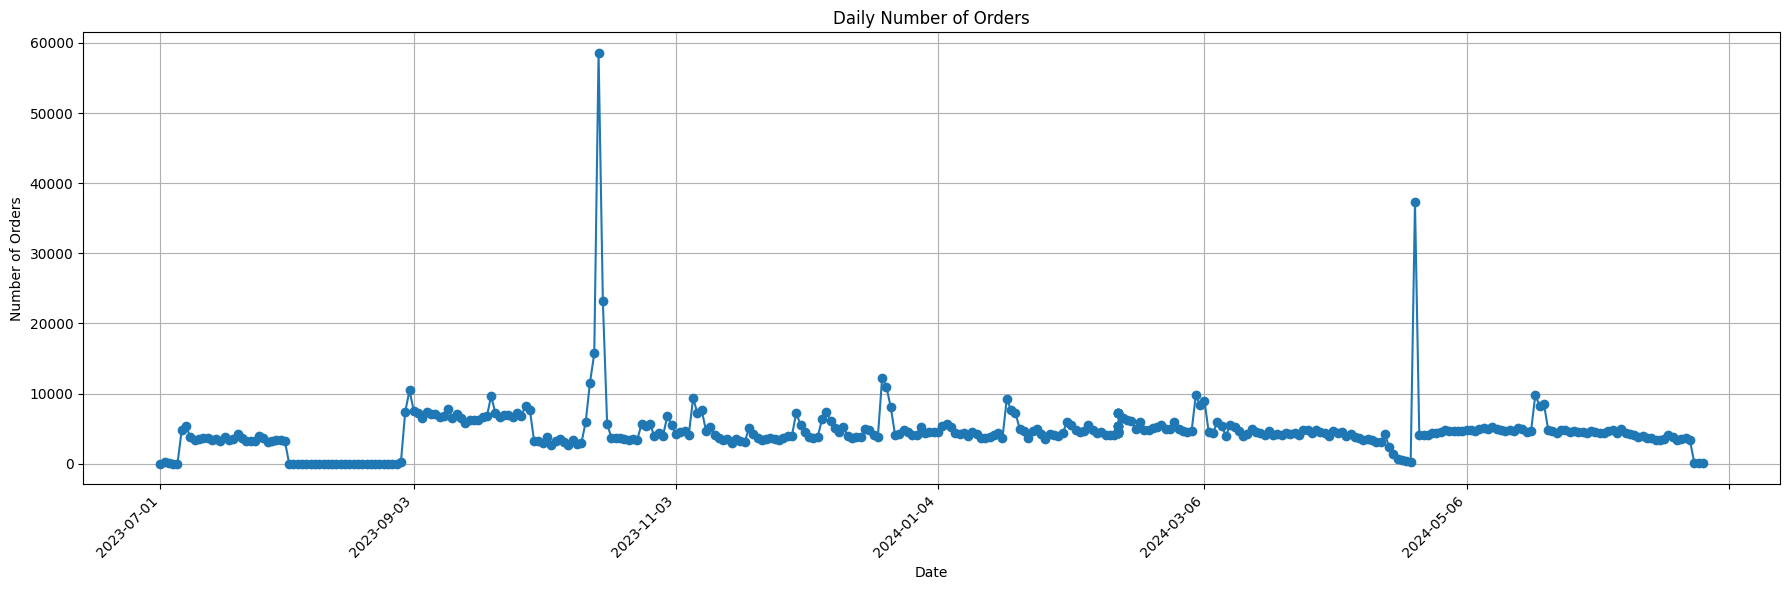

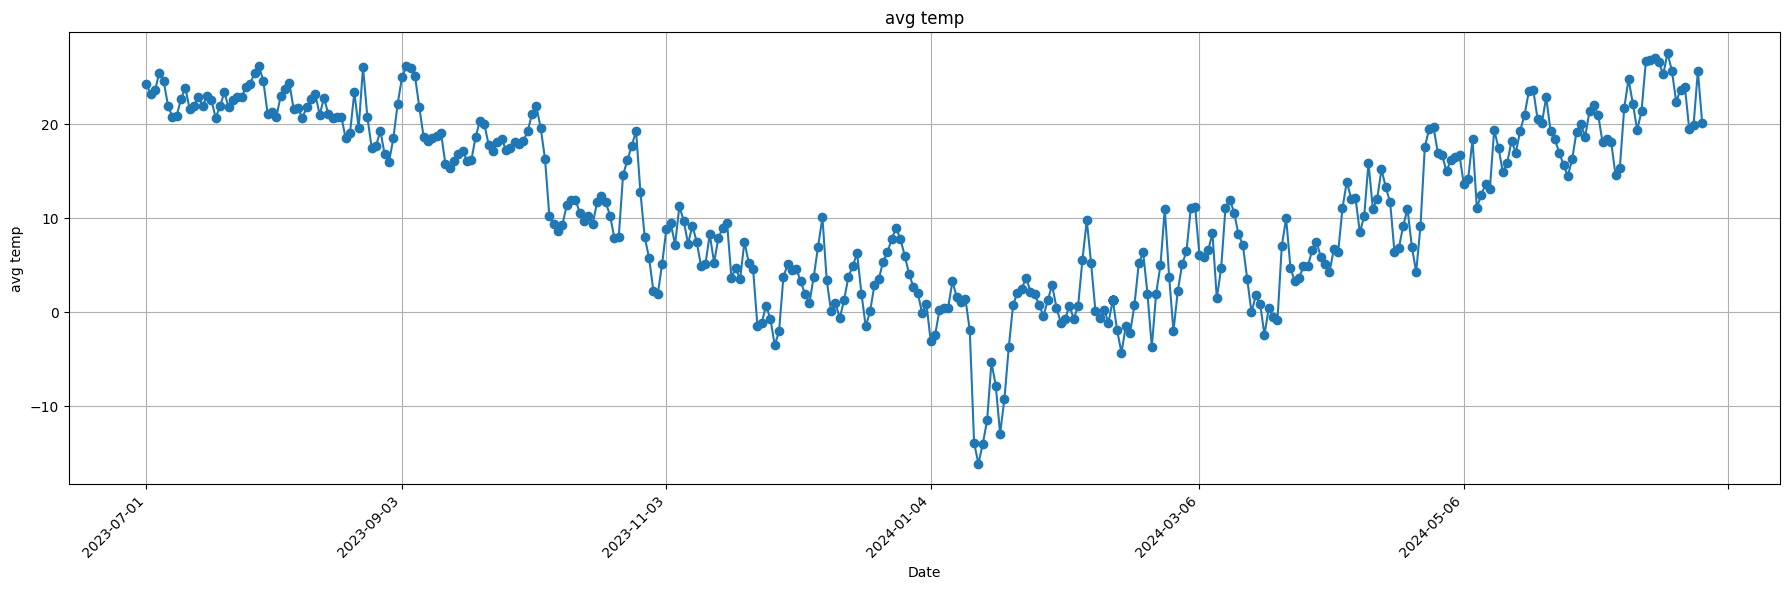

In [24]:
# Creating the plot
plt.figure(figsize=(18, 6))
plt.plot(daily['date'], daily['total_units'], marker='o')

# Formatting
plt.title('Daily Number of Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()

# Creating the plot
plt.figure(figsize=(18, 6))
plt.plot(daily['date'], daily['tavg'], marker='o')

# Formatting
plt.title('avg temp')
plt.xlabel('Date')
plt.ylabel('avg temp')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()

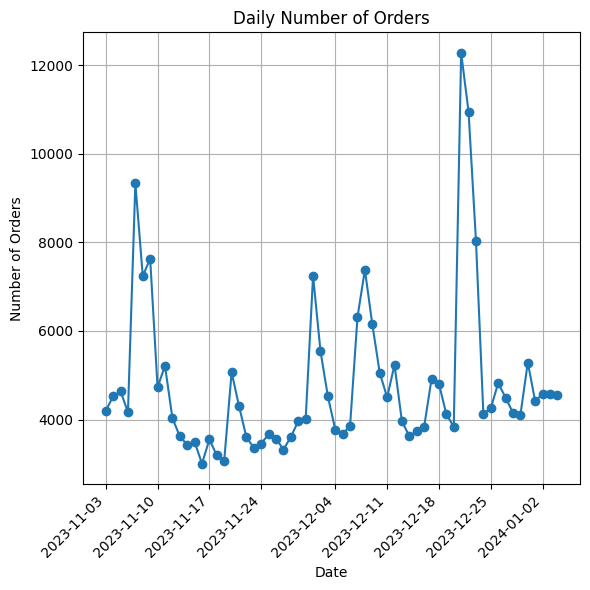

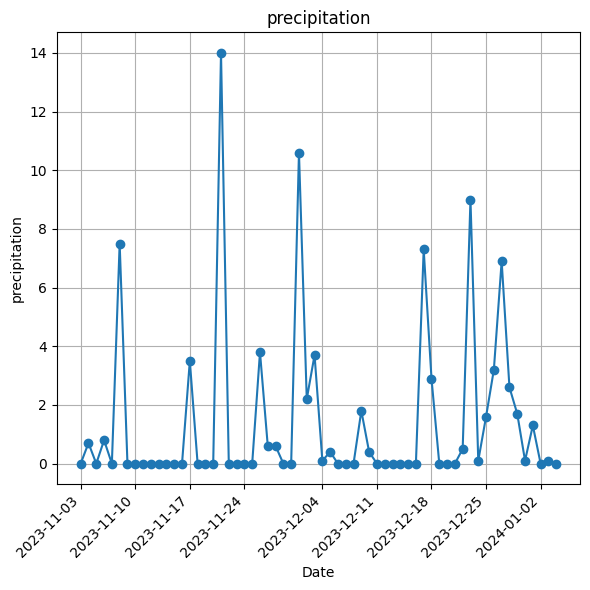

In [25]:
# Creating the plot
plt.figure(figsize=(6, 6))
plt.plot(daily['date'][120:182], daily['total_units'][120:182], marker='o')

# Formatting
plt.title('Daily Number of Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()


# Creating the plot
plt.figure(figsize=(6, 6))
plt.plot(daily['date'][120:182], daily['prcp'][120:182], marker='o')

# Formatting
plt.title('precipitation')
plt.xlabel('Date')
plt.ylabel('precipitation')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()



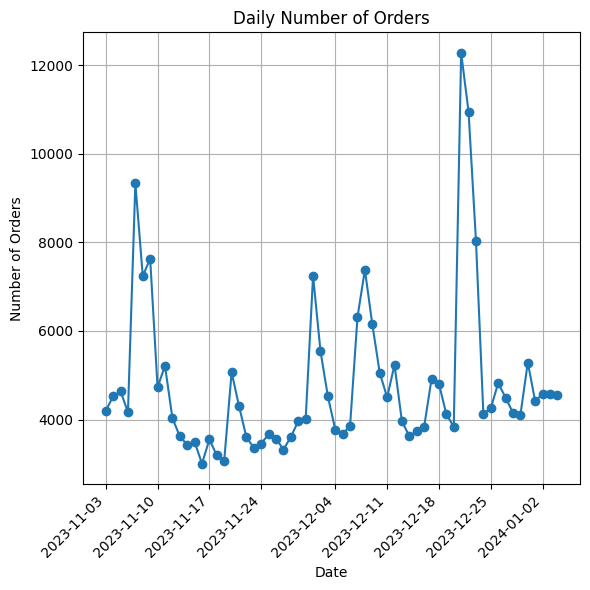

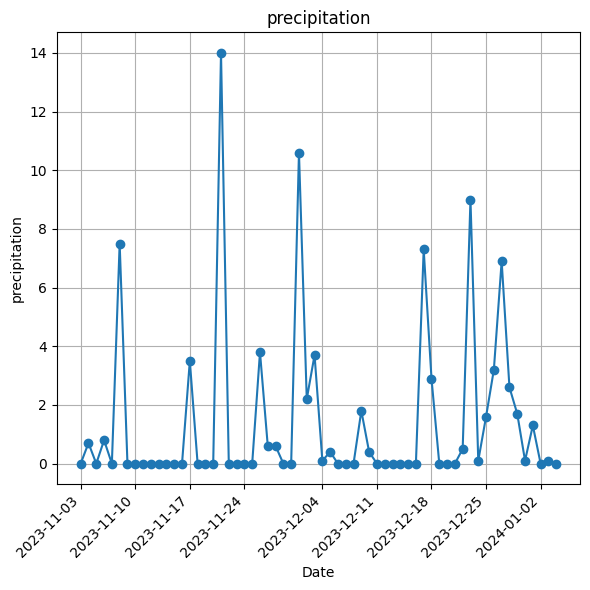

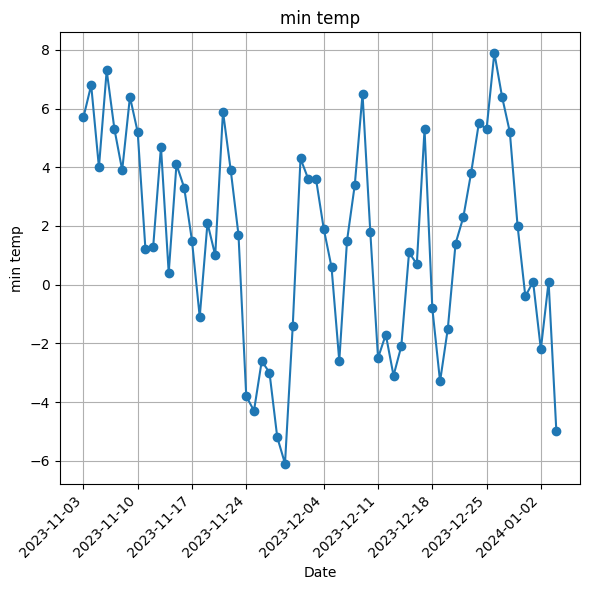

In [26]:
# Creating the plot
plt.figure(figsize=(6, 6))
plt.plot(daily['date'][120:182], daily['total_units'][120:182], marker='o')

# Formatting
plt.title('Daily Number of Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()


# Creating the plot
plt.figure(figsize=(6, 6))
plt.plot(daily['date'][120:182], daily['prcp'][120:182], marker='o')

# Formatting
plt.title('precipitation')
plt.xlabel('Date')
plt.ylabel('precipitation')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()

# Creating the plot
plt.figure(figsize=(6, 6))
plt.plot(daily['date'][120:182], daily['tmin'][120:182], marker='o')

# Formatting
plt.title('min temp')
plt.xlabel('Date')
plt.ylabel('min temp')

# Setting major locator to automatically space out dates
ax = plt.gca()  # Getting current axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjusting date ticks
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatting dates nicely

plt.xticks(rotation=45, ha='right')  # Rotating labels
plt.grid(True)
plt.tight_layout()  # Adjusting layout to prevent overlap

plt.show()

In [27]:
#sales immportant
daily[daily['total_units']==daily['total_units'].max()]

date  deliverybdays  deliverycdays       sla  \
102  2023-10-16        0.00047       0.000574  4.912837   

     product_procurement_sla  sale   NPS  Stock Index  holidays  \
102                  2.68796     1  44.4       1210.0         0   

     Total Investment       TV    Digital  Sponsorship  Content Marketing  \
102         77.957561  0.19769  19.070041    16.024407           0.000855   

     Online marketing   Affiliates        SEM  Radio  Other  tavg  tmin  tmax  \
102          4.335032     1.750951  36.578585    0.0    0.0  10.2   7.8  12.2   

     prcp  wdir  wspd    pres  Camera_gmv  CameraAccessory_gmv  \
102   0.0   342  20.6  1013.5   10.114252             0.634236   

     EntertainmentSmall_gmv  GameCDDVD_gmv  GamingHardware_gmv  Total_GMV  \
102                4.786526       0.437251            0.766805  16.739072   

     Camera_units  CameraAccessory_units  EntertainmentSmall_units  \
102        6266.0                 5932.0                   38306.0   

     GameCDDVD_units  GamingHardware_units  total_units  Camera_discount  \
102           2193.0                5879.0      58576.0        37.253901   

     CameraAccessory_discount  EntertainmentSmall_discount  \
102                   37.8294                    28.006563   

     GameCDDVD_discount  GamingHardware_discount  
102          -13.217387                27.178707

In [28]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745178 entries, 0 to 745177
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   fsn_id                         745178 non-null  object 
 1   order_date                     745178 non-null  object 
 2   order_id                       745178 non-null  float64
 3   order_item_id                  745178 non-null  float64
 4   gmv                            745178 non-null  float64
 5   units                          745178 non-null  int64  
 6   deliverybdays                  745178 non-null  int64  
 7   deliverycdays                  745178 non-null  int64  
 8   order_payment_type             745178 non-null  object 
 9   sla                            745178 non-null  int64  
 10  cust_id                        745178 non-null  object 
 11  pincode                        745178 non-null  object 
 12  product_mrp                   

In [29]:
hourly['date'] = pd.to_datetime(hourly['dates'])
daily['date'] = pd.to_datetime(daily['date'])
hourly = hourly.merge(daily[['date','sale']], on='date', how='left') #Merging hourly data with daily data
hourly.head(1)

fsn_id           order_date     order_id  order_item_id    gmv  \
0  AUDDGN3Q2GSCBUSX  2023-07-01 00:36:11  165147793.0    209706706.0  305.0   

   units  deliverybdays  deliverycdays order_payment_type  sla  \
0      1              0              0            Prepaid    2   

                  cust_id                 pincode  product_mrp  \
0  -5.23642284503954E+018  -8.08379950629886E+018         1100   

   product_procurement_sla product_analytic_category  \
0                        2        EntertainmentSmall   

  product_analytic_sub_category product_analytic_vertical  Day  Month  Year  \
0                AudioMP3Player            AudioMP3Player    1      7  2023   

   List_price   discount       dates       date  sale  
0       305.0  72.272727  2023-07-01 2023-07-01   0.0

# IMPACT ANALYSIS

Channel 'Online Marketing' not found in data. Skipping...
Channel 'Affiliates' not found in data. Skipping...


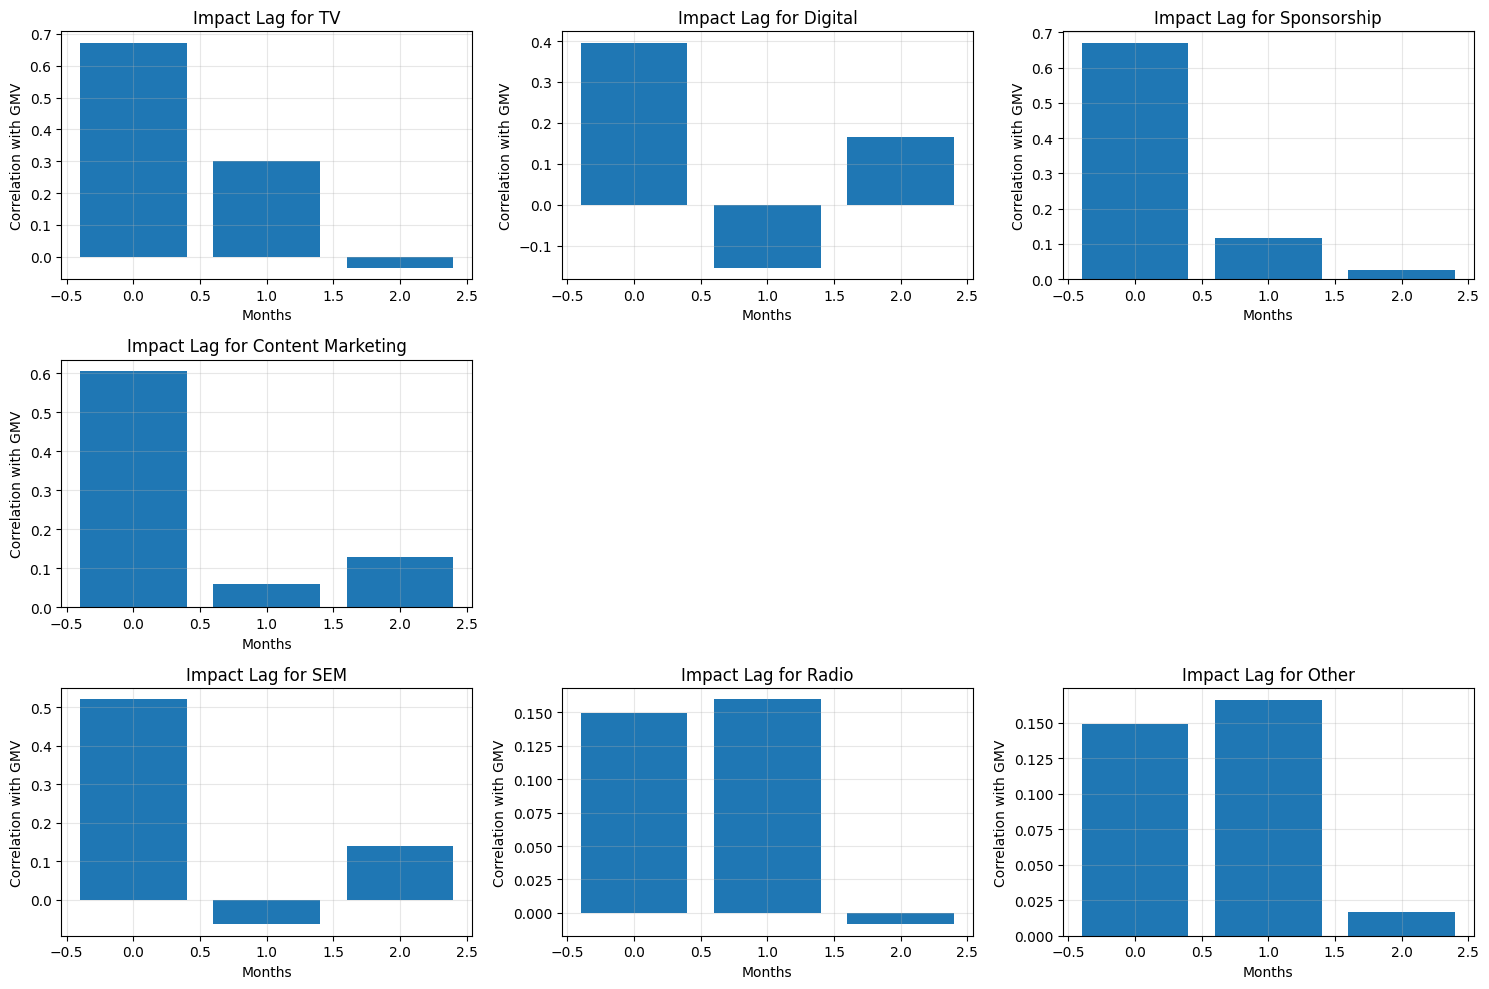

Optimal lag (months) for each channel: {'TV': np.int64(0), 'Digital': np.int64(0), 'Sponsorship': np.int64(0), 'Content Marketing': np.int64(0), 'SEM': np.int64(0), 'Radio': np.int64(1), 'Other': np.int64(1)}


In [30]:
# List of marketing channels
channels = ['TV', 'Digital', 'Sponsorship', 'Content Marketing',
            'Online Marketing', 'Affiliates', 'SEM', 'Radio', 'Other']

max_lag = 3  # Maximum lag in months
lag_correlations = {}

plt.figure(figsize=(15, 10))

for i, channel in enumerate(channels):
    # Checking if the channel exists in the dataset
    if channel in monthly.columns:
        # Computing cross-correlation for monthly data
        correlation = ccf(monthly['Total_GMV'], monthly[channel], adjusted=False)[:max_lag]
        lag_correlations[channel] = correlation

        # Plot
        plt.subplot(3, 3, i+1)
        plt.bar(range(max_lag), correlation)
        plt.title(f'Impact Lag for {channel}')
        plt.xlabel('Months')
        plt.ylabel('Correlation with GMV')
        plt.grid(True, alpha=0.3)
    else:
        print(f"Channel '{channel}' not found in data. Skipping...")

plt.tight_layout()
plt.show()

# Find optimal lag for each channel
optimal_lags = {channel: np.argmax(corrs) for channel, corrs in lag_correlations.items()}
print("Optimal lag (months) for each channel:", optimal_lags)


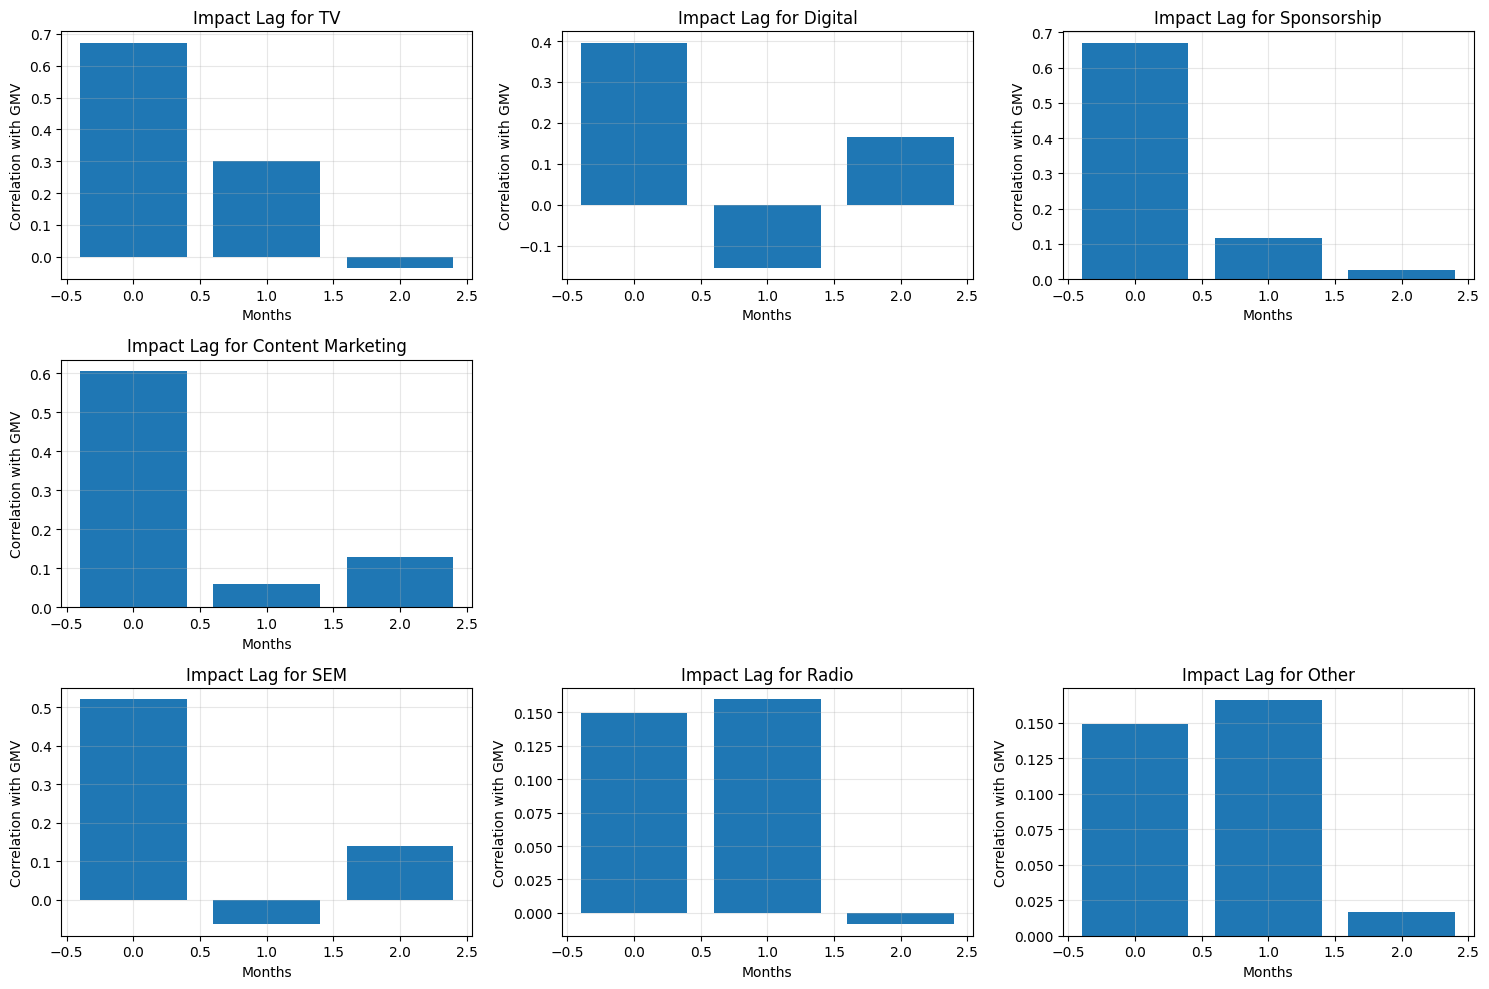

Optimal lag (months) for each channel: {'TV': np.int64(0), 'Digital': np.int64(0), 'Sponsorship': np.int64(0), 'Content Marketing': np.int64(0), 'SEM': np.int64(0), 'Radio': np.int64(1), 'Other': np.int64(1)}


In [31]:
# List of marketing channels
channels = ['TV', 'Digital', 'Sponsorship', 'Content Marketing',
            'Online Marketing', 'Affiliates', 'SEM', 'Radio', 'Other']

max_lag = 3  # Maximum lag in months
lag_correlations = {}

# Set subplot size dynamically
rows = (len(channels) // 3) + (len(channels) % 3 > 0)
plt.figure(figsize=(15, 10))

for i, channel in enumerate(channels):
    if channel in monthly.columns:
        # Compute cross-correlation for monthly data
        x = monthly['Total_GMV'].values
        y = monthly[channel].values
        correlation = ccf(x, y, adjusted=False)[:min(max_lag, len(ccf(x, y)))]
        lag_correlations[channel] = correlation

        # Plot results
        plt.subplot(rows, 3, i+1)
        plt.bar(range(len(correlation)), correlation)
        plt.title(f'Impact Lag for {channel}')
        plt.xlabel('Months')
        plt.ylabel('Correlation with GMV')
        plt.grid(True, alpha=0.3)
    else:
        print(f"Warning: '{channel}' not found in the dataset. Skipping...")

plt.tight_layout()
plt.show()

# Find optimal lag for each channel
optimal_lags = {channel: (np.argmax(corrs) if len(corrs) > 0 else None) for channel, corrs in lag_correlations.items()}
print("Optimal lag (months) for each channel:", optimal_lags)


# SPLINE

In [32]:
monthly

month  deliverybdays  deliverycdays       sla  product_mrp  \
0   2023-07       0.984199   1.029861e-07  0.000018     0.010130   
1   2023-08       2.500000   3.000000e-07  0.000015     0.006376   
2   2023-09       0.034961   4.023364e-09  0.000017     0.009957   
3   2023-10       0.039654   4.662946e-09  0.000019     0.011638   
4   2023-11       0.015353   1.841428e-09  0.000017     0.011336   
5   2023-12       0.046775   5.487294e-09  0.000018     0.013480   
6   2024-01       0.446951   5.215808e-08  0.000018     0.013208   
7   2024-02       1.743189   2.034085e-07  0.000026     0.016908   
8   2024-03       8.994254   1.045935e-06  0.000018     0.013023   
9   2024-04      97.599277   1.128805e-05  0.000016     0.012815   
10  2024-05     111.458237   1.276079e-05  0.000017     0.012484   
11  2024-06     106.272480   1.215467e-05  0.000016     0.011903   

    product_procurement_sla          sale       NPS  Stock Index  holidays  \
0                  0.000012  2.000000e-07  0.000164      35310.0         1   
1                  0.000007  6.000000e-07  0.000162      32562.0         1   
2                  0.000019  0.000000e+00  0.000141      33030.0         1   
3                  0.000014  3.000000e-07  0.000138      37510.0         2   
4                  0.000014  8.000000e-07  0.000141      36990.0         1   
5                  0.000016  7.000000e-07  0.000142      32178.0         2   
6                  0.000015  5.000000e-07  0.000141      31560.0         0   
7                  0.000024  2.100000e-06  0.000221      53768.0        18   
8                  0.000015  3.000000e-07  0.000152      31465.0         3   
9                  0.000017  0.000000e+00  0.000155      37260.0         0   
10                 0.000018  3.000000e-07  0.000147      38068.0         2   
11                 0.000031  0.000000e+00  0.000151      35820.0         3   

    Total Investment        TV    Digital  Sponsorship  Content Marketing  \
0          16.511396  0.208384   2.451304     7.175100           0.000903   
1           4.410847  0.005607   1.113161     0.926128           0.000006   
2          96.254380  3.879504   1.356528    62.787651           0.610292   
3         170.156297  6.144711  12.622480    84.672532           3.444075   
4          51.216220  4.220630   1.275469    14.172116           0.168633   
5         106.745312  5.397502   3.063360    56.705419           1.067307   
6          71.802581  4.238710   0.441290     4.064516           0.870968   
7          72.906483  3.923598   2.901953    17.790498           0.905446   
8         100.024621  9.300000   2.100000    41.590000           0.370000   
9          56.848241  5.205196   0.871892    24.308354           0.034876   
10         78.057000  1.370000   0.770000    31.680000           0.790000   
11         42.834216  1.662717   1.420761    25.048541           0.045081   

    Online marketing   Affiliates        SEM     Radio      Other   tavg  \
0           1.284462     0.529601   4.861643  0.000000   0.000000  688.8   
1           0.112568     0.064176   2.189202  0.000000   0.000000  565.7   
2          16.379990     5.038266   6.202149  0.000000   0.000000  573.0   
3          24.371778     6.973711  31.927011  0.000000   0.000000  387.9   
4          19.561574     6.595767   5.222032  0.000000   0.000000  152.7   
5          22.503756     6.826938  11.181030  0.000000   0.000000  119.8   
6          22.161290     7.132258   4.064516  2.612903  26.216129  -77.5   
7          30.181521     9.808994   7.394473  0.000000   0.000000   63.0   
8          18.437818     6.217667   5.193591  0.870000  15.945545  160.3   
9          16.514510     5.693456   4.219958  0.000000   0.000000  317.4   
10         23.650000     6.800000   6.910000  1.100000   4.987000  532.8   
11          7.971300     2.768023   3.735516  0.000000   0.000000  657.6   

     tmin   tmax   prcp  wdir   wspd     pres  Camera_gmv  \
0   569.8  809.4   86.5  6058  426.6  30388.5    4.644

In [33]:
# Fit a quadratic curve
x = monthly['Total_GMV']
y = monthly['Total Investment']
coefs = np.polyfit(x, y, 2)  # Quadratic fit (degree 2)
poly = np.poly1d(coefs)

# Generate curve points
x_range = np.linspace(x.min(), x.max(), 100)
y_pred = poly(x_range)

# Compute correlation
corr_pearson, _ = pearsonr(x, y)
corr_spearman, _ = spearmanr(x, y)

# Create figure
fig = go.Figure()

# Scatter plot
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(color='royalblue', size=8, opacity=0.7, line=dict(width=1, color='black')),
    name='Data Points'
))

# Quadratic Fit Line
fig.add_trace(go.Scatter(
    x=x_range, y=y_pred,
    mode='lines',
    line=dict(color='darkred', width=2, dash='dash'),
    name='Quadratic Fit'
))

# Add correlation annotation
fig.add_annotation(
    x=x.max() * 0.7, y=y.min() * 1.1,
    text=f"Pearson: {corr_pearson:.2f}<br>Spearman: {corr_spearman:.2f}",
    showarrow=False,
    font=dict(size=14, color="black"),
    bgcolor="white",
    opacity=0.7
)

# Layout settings
fig.update_layout(
    title="Effect of TV Investment on Total GMV",
    xaxis_title="Total GMV",
    yaxis_title="TV Investment",
    template="plotly_white",
    hovermode="x",
    showlegend=True,
    width=800, height=600
)

# Show the plot
fig.show()


In [34]:

# Fit a quadratic curve
x = monthly['Total_GMV']
y = monthly['TV']
coefs = np.polyfit(x, y, 2)  # Quadratic fit (degree 2)
poly = np.poly1d(coefs)

# Generate curve points
x_range = np.linspace(x.min(), x.max(), 100)
y_pred = poly(x_range)

# Compute correlation
corr_pearson, _ = pearsonr(x, y)
corr_spearman, _ = spearmanr(x, y)

# Create figure
fig = go.Figure()

# Scatter plot
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(color='royalblue', size=8, opacity=0.7, line=dict(width=1, color='black')),
    name='Data Points'
))

# Quadratic Fit Line
fig.add_trace(go.Scatter(
    x=x_range, y=y_pred,
    mode='lines',
    line=dict(color='darkred', width=2, dash='dash'),
    name='Quadratic Fit'
))

# Add correlation annotation
fig.add_annotation(
    x=x.max() * 0.7, y=y.min() * 1.1,
    text=f"Pearson: {corr_pearson:.2f}<br>Spearman: {corr_spearman:.2f}",
    showarrow=False,
    font=dict(size=14, color="black"),
    bgcolor="white",
    opacity=0.7
)

# Layout settings
fig.update_layout(
    title="Effect of TV Investment on Total GMV",
    xaxis_title="Total GMV",
    yaxis_title="TV Investment",
    template="plotly_white",
    hovermode="x",
    showlegend=True,
    width=800, height=600
)

# Show the plot
fig.show()



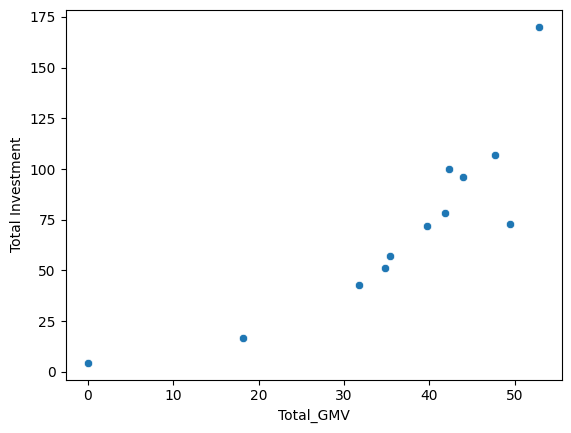

In [35]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Total Investment',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

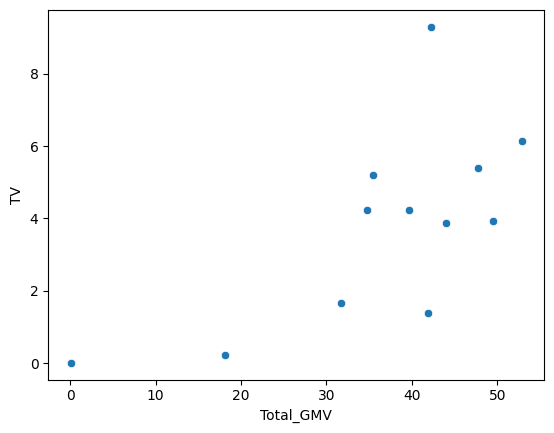

In [36]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='TV',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

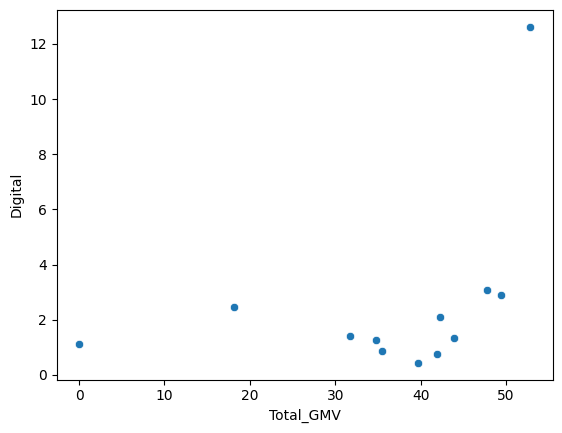

In [37]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Digital',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

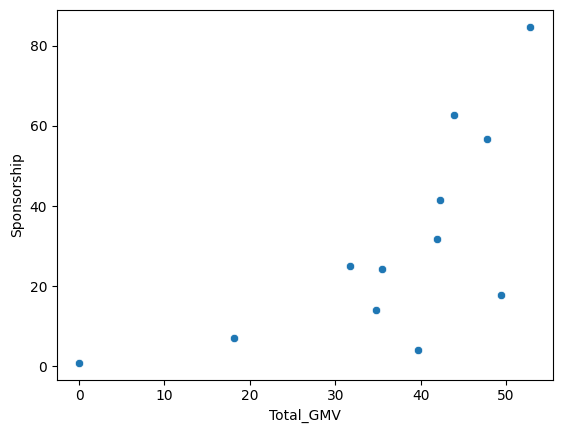

In [38]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Sponsorship',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

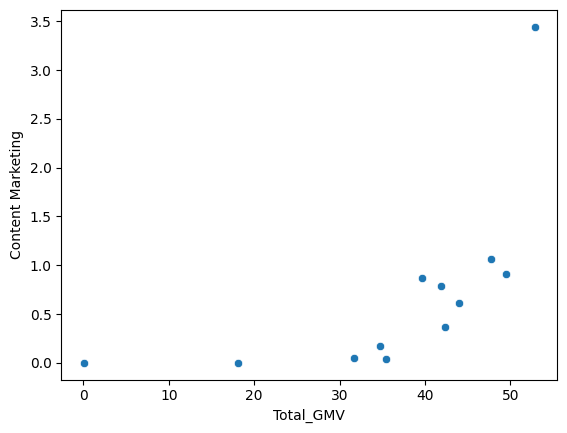

In [39]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Content Marketing',data=monthly)


corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

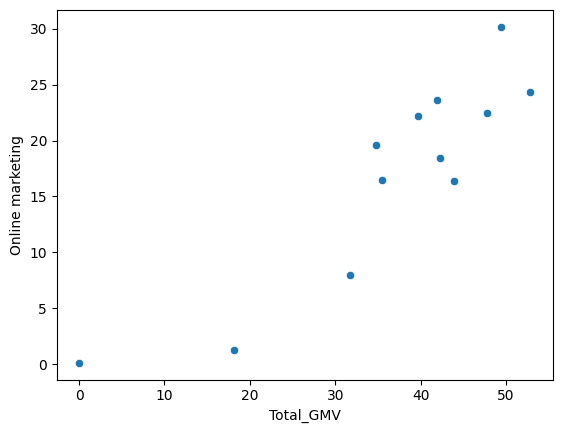

In [40]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Online marketing',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

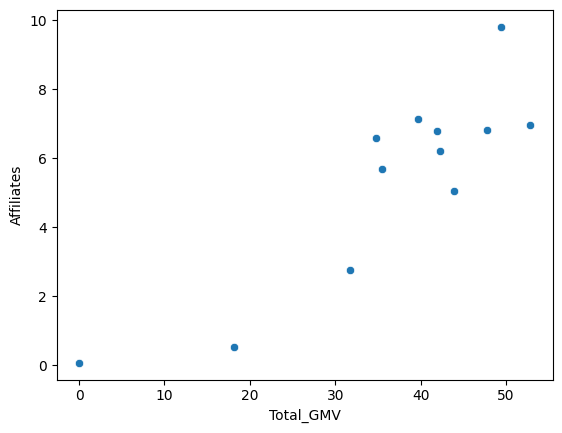

In [41]:
# Clean column names to avoid issues
monthly.columns = monthly.columns.str.strip()

# Scatter plot to test the effect of total investment on GMV
sns.scatterplot(x='Total_GMV', y='Affiliates', data=monthly)

# Calculate correlation values
corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])




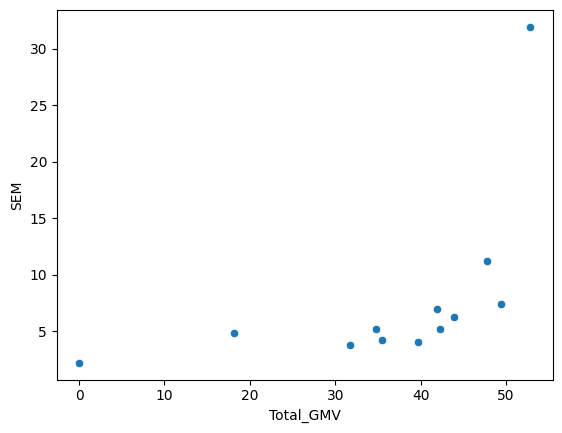

In [42]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='SEM',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

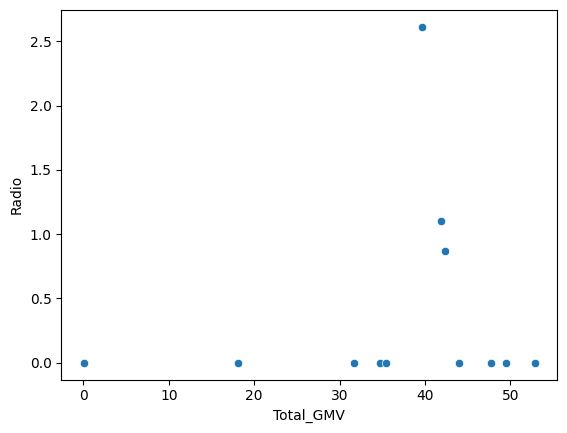

In [43]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Radio',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

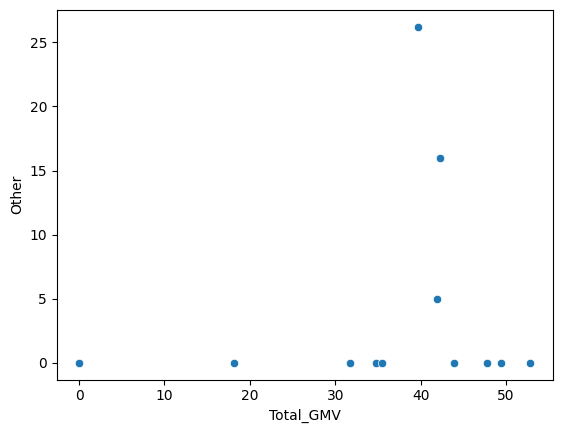

In [44]:
# Testing effect of total investment on GMV
sns.scatterplot(x='Total_GMV',y='Other',data=monthly)

corr_pearson, p_value_pearson = pearsonr(monthly['Total_GMV'], monthly['Total Investment'])
corr_spearman, p_value_spearman = spearmanr(monthly['Total_GMV'], monthly['Total Investment'])

In [45]:
x = monthly['Total_GMV'].values.tolist()
y = monthly['Content Marketing'].values.tolist()
x.append(0)
y.append(0)
# Sort x and y based on x values
sorted_indices = np.argsort(x)
x_sorted = np.array(x)[sorted_indices]
y_sorted = np.array(y)[sorted_indices]

# Remove duplicate x values and corresponding y values
x_unique, index = np.unique(x_sorted, return_index=True)
y_unique = y_sorted[index]

# Apply Cubic Spline Interpolation using the sorted and unique x values
cs_total = CubicSpline(x_unique, y_unique, bc_type='clamped')
cs=interp1d(x_unique, y_unique)

#DISCOUNT EFFECT


In [47]:
hourly = pd.read_csv('hourly.csv')
hourly.drop(columns='Unnamed: 0', inplace=True)

<ipython-input-47-50e3116916a0>:1: DtypeWarning:

Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.



#Discount%:
Discount% = 100*(product_mrp – list price) / product_mrp

In [48]:
print(hourly.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136055 entries, 0 to 1136054
Data columns (total 23 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   fsn_id                         1136055 non-null  object 
 1   order_date                     1136054 non-null  object 
 2   order_id                       1136054 non-null  float64
 3   order_item_id                  1136054 non-null  float64
 4   gmv                            1136054 non-null  float64
 5   units                          1136054 non-null  float64
 6   deliverybdays                  1136054 non-null  float64
 7   deliverycdays                  1136054 non-null  float64
 8   order_payment_type             1136054 non-null  object 
 9   sla                            1136054 non-null  float64
 10  cust_id                        1136054 non-null  object 
 11  pincode                        1136054 non-null  object 
 12  product_mrp   

In [49]:
hourly.describe()

order_id  order_item_id           gmv         units  deliverybdays  \
count  1.136054e+06   1.136054e+06  1.136054e+06  1.136054e+06   1.136054e+06   
mean   2.730385e+15   1.711169e+16  2.552888e+03  1.023913e+00   1.385409e-02   
std    1.316280e+15   6.385622e+16  8.526937e+03  2.711664e-01   1.019098e+00   
min    7.633152e+07   1.080165e+08  0.000000e+00  1.000000e+00   0.000000e+00   
25%    1.510068e+15   1.513433e+15  3.490000e+02  1.000000e+00   0.000000e+00   
50%    2.521155e+15   2.526663e+15  7.980000e+02  1.000000e+00   0.000000e+00   
75%    3.518886e+15   4.396022e+15  1.999000e+03  1.000000e+00   0.000000e+00   
max    5.395077e+15   3.000373e+17  4.375000e+06  5.000000e+01   1.480000e+02   

       deliverycdays           sla   product_mrp  product_procurement_sla  \
count   1.136054e+06  1.136054e+06  1.136054e+06             1.136054e+06   
mean    1.611895e-02  5.780211e+00  4.134716e+03             4.914097e+00   
std     1.189857e+00  2.813083e+00  8.492158e+03             4.860240e+01   
min     0.000000e+00  0.000000e+00  4.900000e+01            -1.000000e+00   
25%     0.000000e+00  4.000000e+00  7.990000e+02             1.000000e+00   
50%     0.000000e+00  6.000000e+00  1.500000e+03             2.000000e+00   
75%     0.000000e+00  8.000000e+00  3.499000e+03             3.000000e+00   
max     1.720000e+02  1.750000e+02  2.999990e+05             1.000000e+03   

                Day         Month          Year    List_price      discount  
count  1.136054e+06  1.136054e+06  1.136054e+06  1.136054e+06  1.136054e+06  
mean   1.538130e+01  7.485499e+00  2.023301e+03  3.624827e+03 -1.121720e+01  
std    8.456297e+00  3.993744e+00  4.588039e-01  2.481612e+05  9.843975e+03  
min    1.000000e+00  1.000000e+00  2.023000e+03  0.000000e+00 -8.745000e+06  
25%    8.000000e+00  2.000000e+00  2.023000e+03  3.490000e+02  2.650000e+01  
50%    1.600000e+01  9.000000e+00  2.023000e+03  7.990000e+02  4.423462e+01  
75%    2.200000e+01  1.100000e+01  2.024000e+03  1.999000e+03  5.984925e+01  
max    3.100000e+01  1.200000e+01  2.024000e+03  2.187500e+08  4.000000e+02

In [50]:
hourly.columns

Index(['fsn_id', 'order_date', 'order_id', 'order_item_id', 'gmv', 'units',
       'deliverybdays', 'deliverycdays', 'order_payment_type', 'sla',
       'cust_id', 'pincode', 'product_mrp', 'product_procurement_sla',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'Day', 'Month', 'Year', 'List_price',
       'discount', 'dates'],
      dtype='object')

In [51]:
# Data overview
print(hourly.info())
print(hourly.describe())

# Calculate list_price
hourly['list_price'] = hourly['gmv'] / hourly['units']
# Calculate discount percentage
hourly['discount_pct'] = 100 * (hourly['product_mrp'] - hourly['list_price']) / hourly['product_mrp']

# Calculate revenue
hourly['revenue'] = hourly['list_price'] * hourly['units']

# Basic data cleaning
# Replace inf or -inf values that might result from division by zero
hourly.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove records with NaN discount_pct (likely from division by zero when product_mrp=0)
hourly = hourly.dropna(subset=['discount_pct'])
# Filter out unrealistic discount percentages (e.g., negative or >100%)
hourly = hourly[(hourly['discount_pct'] >= 0) & (hourly['discount_pct'] <= 100)]

# Print summary statistics for key columns
print("\nSummary Statistics for Key Metrics:")
print(hourly[['product_mrp', 'list_price', 'units', 'discount_pct', 'revenue']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136055 entries, 0 to 1136054
Data columns (total 23 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   fsn_id                         1136055 non-null  object 
 1   order_date                     1136054 non-null  object 
 2   order_id                       1136054 non-null  float64
 3   order_item_id                  1136054 non-null  float64
 4   gmv                            1136054 non-null  float64
 5   units                          1136054 non-null  float64
 6   deliverybdays                  1136054 non-null  float64
 7   deliverycdays                  1136054 non-null  float64
 8   order_payment_type             1136054 non-null  object 
 9   sla                            1136054 non-null  float64
 10  cust_id                        1136054 non-null  object 
 11  pincode                        1136054 non-null  object 
 12  product_mrp   

#Discount-Revenue Relationship Analysis


Correlation between Discount% and Revenue: -0.2074
P-value: 0.0000

Correlation between Discount% and Units Sold: -0.0535
P-value: 0.0000


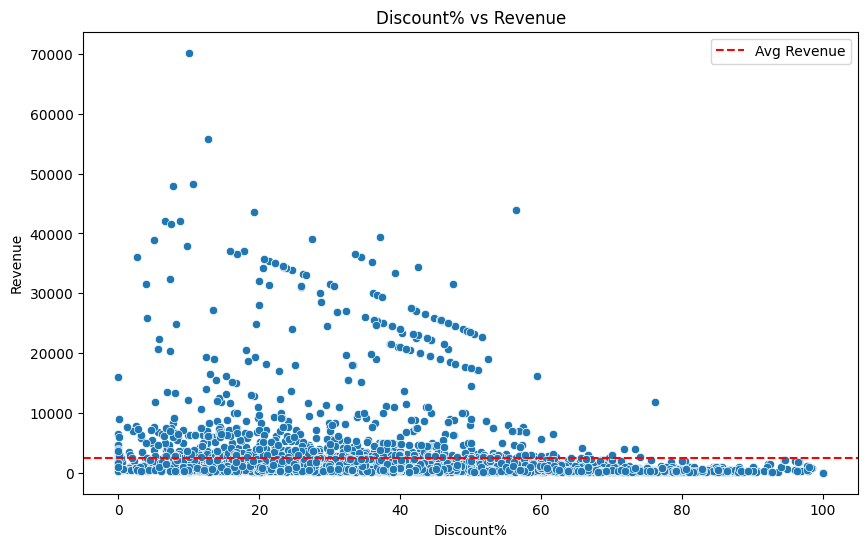

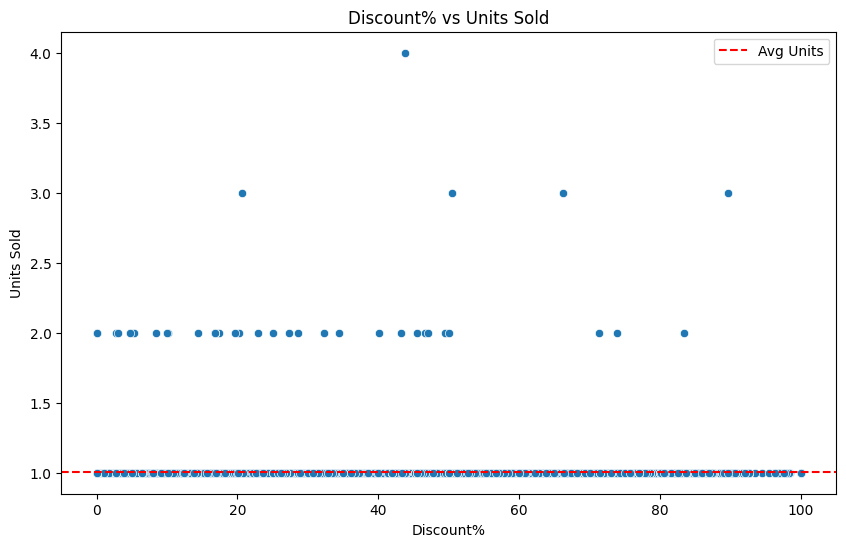

In [52]:
# Drop null values to prevent errors
hourly = hourly.dropna(subset=['discount_pct', 'revenue', 'units'])

# Calculate correlation between discount percentage and revenue
correlation, p_value = pearsonr(hourly['discount_pct'], hourly['revenue'])
print(f"\nCorrelation between Discount% and Revenue: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Calculate correlation between discount percentage and units sold
correlation_units, p_value_units = pearsonr(hourly['discount_pct'], hourly['units'])
print(f"\nCorrelation between Discount% and Units Sold: {correlation_units:.4f}")
print(f"P-value: {p_value_units:.4f}")

# Sample rows for better visualization (check row count before sampling)
n_samples = min(5000, len(hourly))

# Visualize Discount% vs Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_pct', y='revenue', data=hourly.sample(n_samples))
plt.title('Discount% vs Revenue')
plt.xlabel('Discount%')
plt.ylabel('Revenue')
plt.axhline(y=hourly['revenue'].mean(), color='r', linestyle='--', label='Avg Revenue')
plt.legend()
plt.show()

# Visualize Discount% vs Units Sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_pct', y='units', data=hourly.sample(n_samples))
plt.title('Discount% vs Units Sold')
plt.xlabel('Discount%')
plt.ylabel('Units Sold')
plt.axhline(y=hourly['units'].mean(), color='r', linestyle='--', label='Avg Units')
plt.legend()
plt.show()



Correlation between Discount% and Revenue: -0.2074
P-value: 0.0000

Correlation between Discount% and Units Sold: -0.0535
P-value: 0.0000


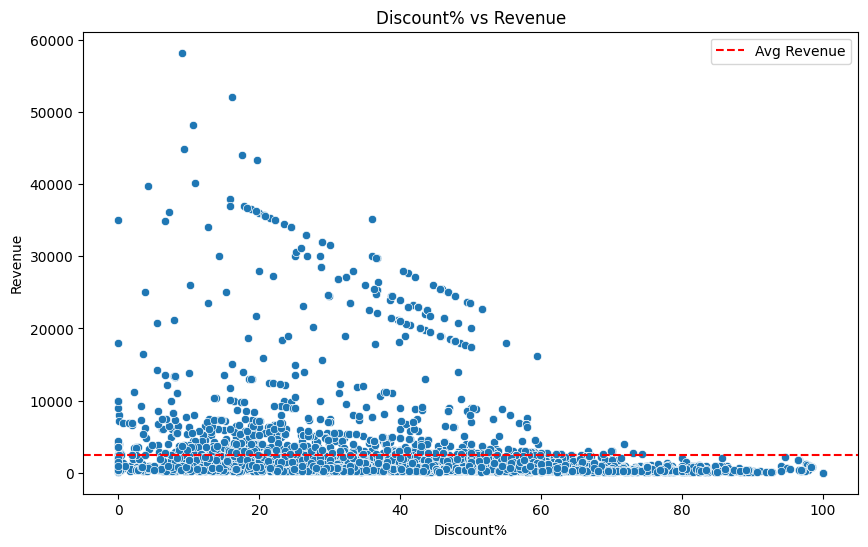

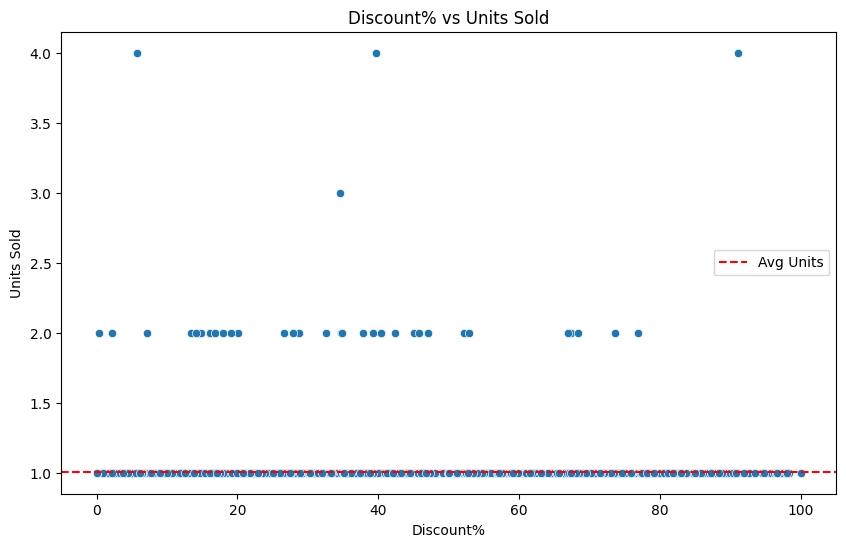

In [53]:
# Calculate correlation between discount percentage and revenue
correlation, p_value = pearsonr(hourly['discount_pct'], hourly['revenue'])
print(f"\nCorrelation between Discount% and Revenue: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Calculate correlation between discount percentage and units sold
correlation_units, p_value_units = pearsonr(hourly['discount_pct'], hourly['units'])
print(f"\nCorrelation between Discount% and Units Sold: {correlation_units:.4f}")
print(f"P-value: {p_value_units:.4f}")

# Visualize the relationship using scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_pct', y='revenue', data=hourly.sample(5000))  # Sample for better visualization
plt.title('Discount% vs Revenue')
plt.xlabel('Discount%')
plt.ylabel('Revenue')
plt.axhline(y=hourly['revenue'].mean(), color='r', linestyle='--', label='Avg Revenue')
plt.legend()
plt.show()

# Visualize the relationship between discount and units sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_pct', y='units', data=hourly.sample(5000))
plt.title('Discount% vs Units Sold')
plt.xlabel('Discount%')
plt.ylabel('Units Sold')
plt.axhline(y=hourly['units'].mean(), color='r', linestyle='--', label='Avg Units')
plt.legend()
plt.show()


#Discount Bucket Analysis

<ipython-input-54-8b5bc749810b>:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Revenue and Sales Metrics by Discount Buckets:
  discount_bucket       revenue     units  order_id  cust_id  avg_order_value  \
0            0-5%  7.297118e+07   22260.0     18490    17737      3946.521631   
1           5-10%  1.252648e+08   31230.0     26912    25907      4654.607659   
2          10-15%  1.586583e+08   44693.0     38503    37153      4120.673896   
3          15-20%  2.149534e+08   51433.0     43675    42097      4921.658704   
4          20-25%  2.411458e+08   60898.0     53704    51667      4490.275914   
5          25-30%  2.294250e+08   69412.0     61716    59079      3717.431919   
6          30-40%  4.485301e+08  146530.0    130728   123552      3431.017727   
7          40-50%  7.004283e+08  204271.0    182896   171614      3829.653548   
8          50-75%  3.849060e+08  376141.0    343022   312918      1122.103047   
9         75-100%  4.073171e+07   85501.0     77379    72048       526.392270   

   avg_units_per_order  
0             1.203894  
1         

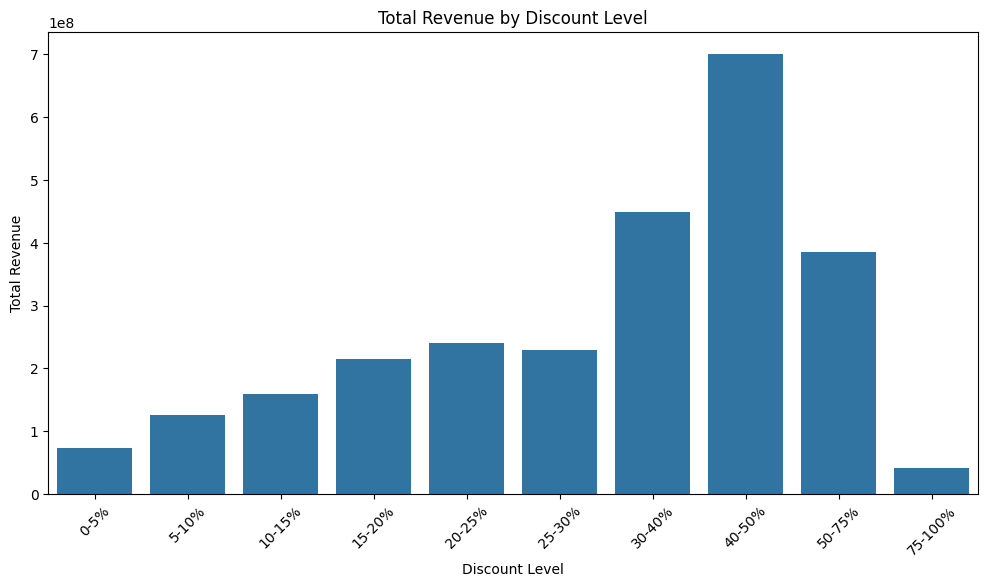

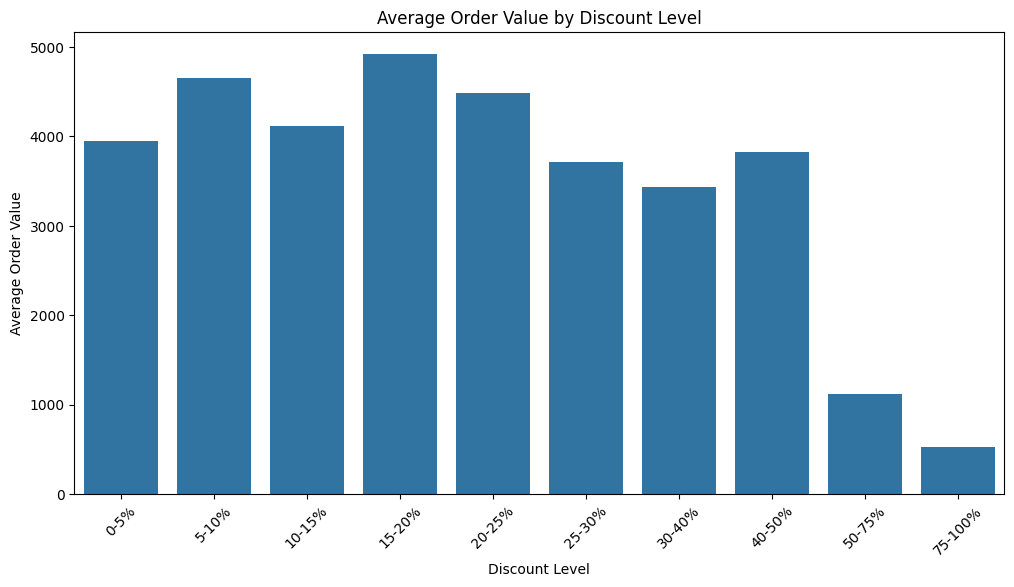

In [54]:
# Create discount buckets for easier analysis
bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%',
          '25-30%', '30-40%', '40-50%', '50-75%', '75-100%']
hourly['discount_bucket'] = pd.cut(hourly['discount_pct'], bins=bins, labels=labels)

# Analyze revenue by discount buckets
discount_revenue = hourly.groupby('discount_bucket').agg({
    'revenue': 'sum',
    'units': 'sum',
    'order_id': 'nunique',
    'cust_id': 'nunique'
}).reset_index()

# Calculate average order value and units per order
discount_revenue['avg_order_value'] = discount_revenue['revenue'] / discount_revenue['order_id']
discount_revenue['avg_units_per_order'] = discount_revenue['units'] / discount_revenue['order_id']

# Display the results
print("\nRevenue and Sales Metrics by Discount Buckets:")
print(discount_revenue)

# Visualize revenue across discount buckets
plt.figure(figsize=(12, 6))
sns.barplot(x='discount_bucket', y='revenue', data=discount_revenue)
plt.title('Total Revenue by Discount Level')
plt.xlabel('Discount Level')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

# Visualize average order value across discount buckets
plt.figure(figsize=(12, 6))
sns.barplot(x='discount_bucket', y='avg_order_value', data=discount_revenue)
plt.title('Average Order Value by Discount Level')
plt.xlabel('Discount Level')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)
plt.show()


#Temporal Analysis of Discount Effects


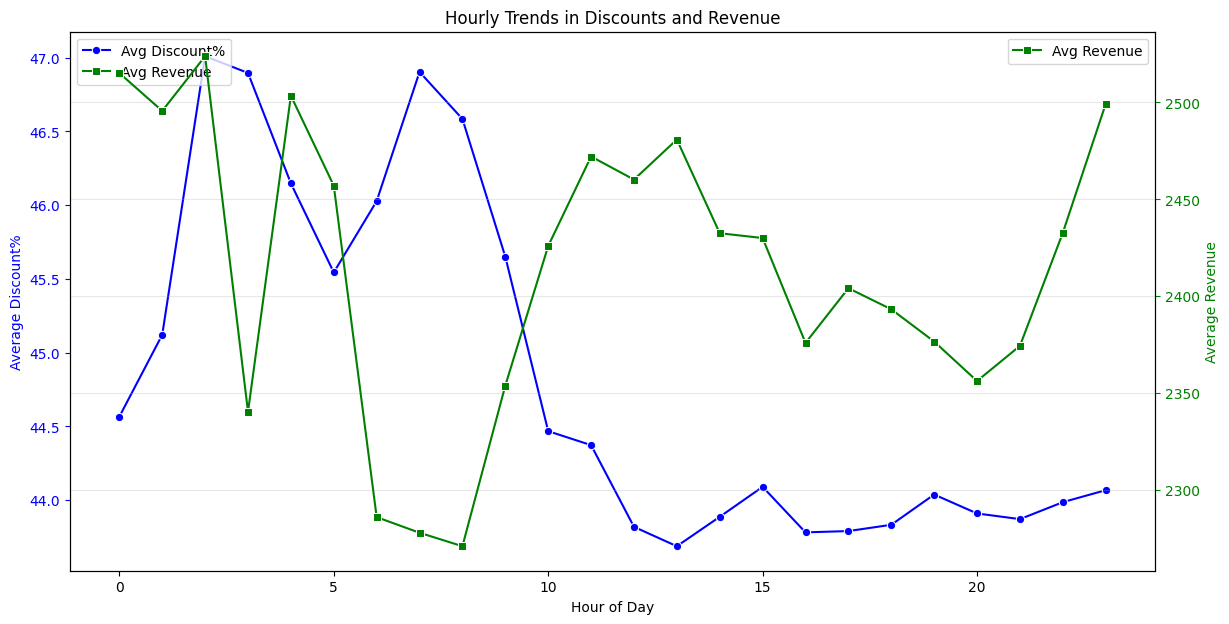

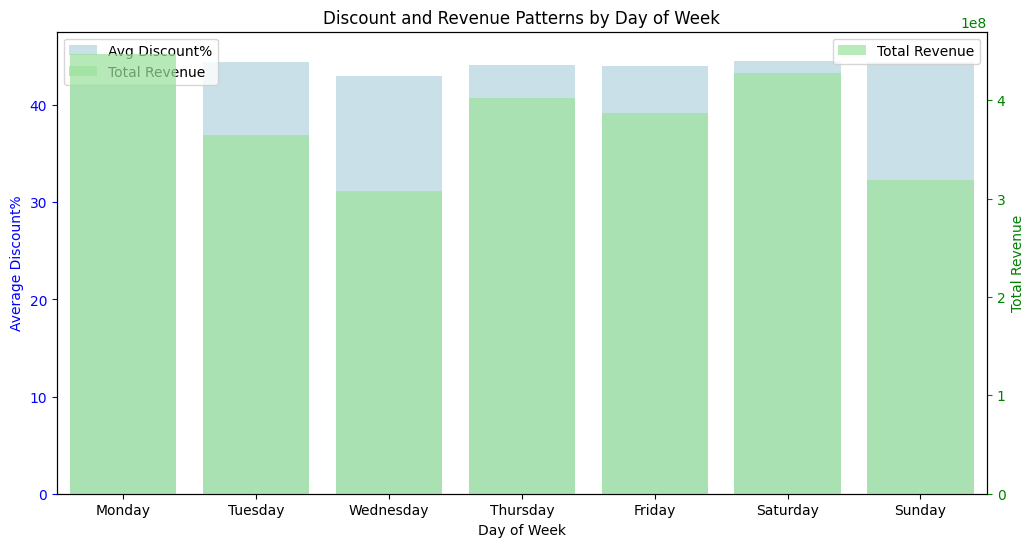

In [55]:
# Convert order_date to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(hourly['order_date']):
    hourly['order_date'] = pd.to_datetime(hourly['order_date'])

# Extract hour, day of week, and month for temporal analysis
hourly['hour'] = hourly['order_date'].dt.hour
hourly['day_of_week'] = hourly['order_date'].dt.day_name()
hourly['month'] = hourly['order_date'].dt.month_name()

# Analyze average discount and revenue by hour of day
hourly_trends = hourly.groupby('hour').agg({
    'discount_pct': 'mean',
    'revenue': 'mean',
    'units': 'mean'
}).reset_index()

# Plot hourly trends
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

sns.lineplot(x='hour', y='discount_pct', data=hourly_trends, marker='o', ax=ax1, color='blue', label='Avg Discount%')
sns.lineplot(x='hour', y='revenue', data=hourly_trends, marker='s', ax=ax2, color='green', label='Avg Revenue')

ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Discount%', color='blue')
ax2.set_ylabel('Average Revenue', color='green')
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='green')

plt.title('Hourly Trends in Discounts and Revenue')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Analyze performance by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_trends = hourly.groupby('day_of_week').agg({
    'discount_pct': 'mean',
    'revenue': 'sum',
    'units': 'sum'
}).reset_index()
weekly_trends['day_of_week'] = pd.Categorical(weekly_trends['day_of_week'], categories=day_order, ordered=True)
weekly_trends = weekly_trends.sort_values('day_of_week')

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

sns.barplot(x='day_of_week', y='discount_pct', data=weekly_trends, ax=ax1, color='lightblue', alpha=0.7, label='Avg Discount%')
sns.barplot(x='day_of_week', y='revenue', data=weekly_trends, ax=ax2, color='lightgreen', alpha=0.7, label='Total Revenue')

ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Average Discount%', color='blue')
ax2.set_ylabel('Total Revenue', color='green')
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='green')

plt.title('Discount and Revenue Patterns by Day of Week')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()

#Category-level Discount Analysis

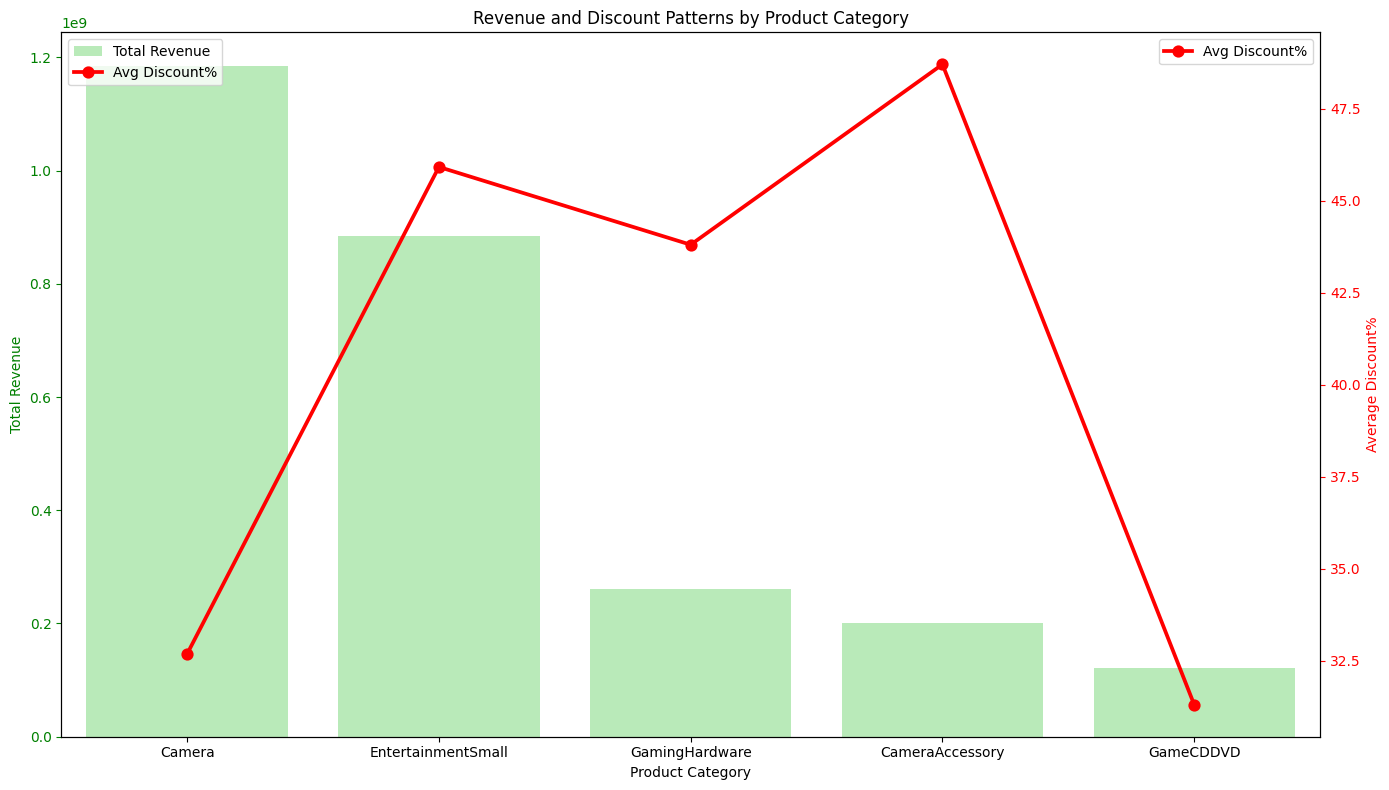

In [56]:
# Assuming 'product_analytic_category' exists in the dataset
# If not, use another category column or skip this section
if 'product_analytic_category' in hourly.columns:
    # Analyze discount and revenue patterns by product category
    category_analysis = hourly.groupby('product_analytic_category').agg({
        'discount_pct': 'mean',
        'revenue': 'sum',
        'units': 'sum',
        'order_id': 'nunique'
    }).reset_index()

    # Calculate average revenue per order by category
    category_analysis['revenue_per_order'] = category_analysis['revenue'] / category_analysis['order_id']

    # Sort by total revenue
    category_analysis = category_analysis.sort_values('revenue', ascending=False).head(10)  # Top 10 categories

    # Plot category-level insights
    plt.figure(figsize=(14, 8))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot bars for revenue
    sns.barplot(x='product_analytic_category', y='revenue', data=category_analysis,
                ax=ax1, color='lightgreen', alpha=0.7, label='Total Revenue')

    # Plot line for average discount
    sns.pointplot(x='product_analytic_category', y='discount_pct', data=category_analysis,
                 ax=ax2, color='red', label='Avg Discount%')

    ax1.set_xlabel('Product Category')
    ax1.set_ylabel('Total Revenue', color='green')
    ax2.set_ylabel('Average Discount%', color='red')
    ax1.tick_params(axis='y', colors='green')
    ax2.tick_params(axis='y', colors='red')

    plt.title('Revenue and Discount Patterns by Product Category')
    plt.xticks(rotation=45, ha='right')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.tight_layout()
    plt.show()


#Regression Analysis for Discount Impact



Regression Analysis Results:
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4610.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:01:43   Log-Likelihood:            -9.9853e+05
No. Observations:              100000   AIC:                         1.997e+06
Df Residuals:                   99998   BIC:                         1.997e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4770

<ipython-input-57-e086b565cbfb>:23: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



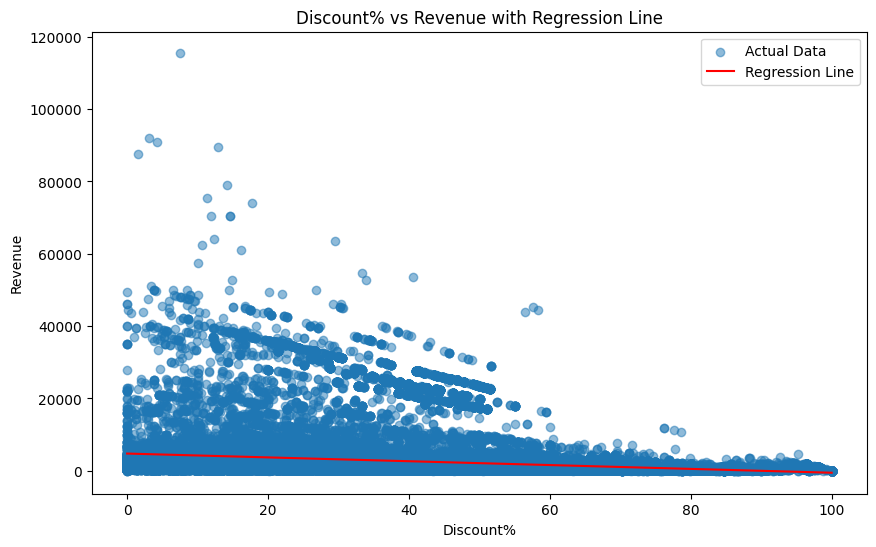

In [57]:
# Create a regression model to quantify the effect of discount on revenue
# Sample the data if it's too large for modeling
model_data = hourly.sample(min(100000, len(hourly)))

# Simple linear regression
X = sm.add_constant(model_data['discount_pct'])
y = model_data['revenue']
model = sm.OLS(y, X).fit()
print("\nRegression Analysis Results:")
print(model.summary())

# More complex model with additional factors (if available in the dataset)
# Assuming you have other relevant columns, adjust as needed
formula = 'revenue ~ discount_pct + units + C(day_of_week) + C(hour)'
complex_model = ols(formula, data=model_data).fit()
print("\nMultivariate Regression Results:")
print(complex_model.summary())

# Visualize the model prediction
plt.figure(figsize=(10, 6))
plt.scatter(model_data['discount_pct'], model_data['revenue'], alpha=0.5, label='Actual Data')
pred_x = np.linspace(model_data['discount_pct'].min(), model_data['discount_pct'].max(), 100)
pred_y = model.params[0] + model.params[1] * pred_x
plt.plot(pred_x, pred_y, 'r', label='Regression Line')
plt.title('Discount% vs Revenue with Regression Line')
plt.xlabel('Discount%')
plt.ylabel('Revenue')
plt.legend()
plt.show()
